In [7]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [6]:
!pip install transformers
!pip install datasets
!pip install pytorch_pretrained_bert

!pip install rouge/requirements.txt
!pip install rouge-score

ERROR: Invalid requirement: 'rouge/requirements.txt'
Hint: It looks like a path. File 'rouge/requirements.txt' does not exist.


In [8]:
%cd '/content/drive/MyDrive/CS685/'

/content/drive/MyDrive/CS685


In [9]:
import os
import time
# from google.colab import drive

import json
import pandas as pd
import seaborn as sns
import numpy as np
import random

import matplotlib.pyplot as plt
%matplotlib inline

import torch
from torch.utils.data import Dataset, DataLoader, random_split, RandomSampler, SequentialSampler

from transformers import AutoModelForCausalLM, AutoTokenizer, AdamW, GPT2LMHeadModel, \
GPT2DoubleHeadsModel, GPT2TokenizerFast, GPT2Config, BertTokenizer
from transformers import AdamW, get_linear_schedule_with_warmup

from datasets import load_dataset
from helper import format_time, rouge
from data import GPT2Dataset, preprocessing, split_data
from plots import loss_curves

import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [10]:
seed_val = 42
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

In [11]:
covid_dialog = load_dataset("covid_qa_ucsd", "en", data_dir="./" )
md_df = pd.read_pickle("./med_dialogue_sample.pickle")
print(covid_dialog)

Downloading:   0%|          | 0.00/3.49k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/805 [00:00<?, ?B/s]

Using custom data configuration en-data_dir=.%2F


0 examples [00:00, ? examples/s]

Dataset covid_qa_ucsd downloaded and prepared to /root/.cache/huggingface/datasets/covid_qa_ucsd/en-data_dir=.%2F/1.0.0/2a15b6e8fdc7cee91951d8f20ac2b26ede79fbef988919fbde22dbb97bf4df81. Subsequent calls will reuse this data.


  0%|          | 0/1 [00:00<?, ?it/s]

DatasetDict({
    train: Dataset({
        features: ['dialogue_id', 'dialogue_url', 'dialogue_turns'],
        num_rows: 572
    })
})


In [12]:
cd_df = covid_dialog['train'].to_pandas()
md_df.drop(columns=["file_name"])
md_df = md_df[0:570]
print(len(md_df))
md_df.head()

570


,file_name,dialogue_id,dialogue_url,dialogue_turns
0,/content/drive/MyDrive/CS685/Medical-Dialogue-...,699,https://www.healthcaremagic.com/questions/What...,"{'speaker': [0, 1], 'utterance': ['What causes..."
1,/content/drive/MyDrive/CS685/Medical-Dialogue-...,1380,https://www.healthcaremagic.com/questions/Coul...,"{'speaker': [0, 1], 'utterance': ['Could frequ..."
2,/content/drive/MyDrive/CS685/Medical-Dialogue-...,1574,https://www.healthcaremagic.com/questions/What...,"{'speaker': [0, 1], 'utterance': ['What can ca..."
3,/content/drive/MyDrive/CS685/Medical-Dialogue-...,2049,https://www.healthcaremagic.com/questions/Can-...,"{'speaker': [0, 1], 'utterance': ['Can someone..."
4,/content/drive/MyDrive/CS685/Medical-Dialogue-...,2239,https://www.healthcaremagic.com/questions/Can-...,"{'speaker': [0, 1], 'utterance': ['Can respira..."


In [13]:
combined = pd.concat([cd_df, md_df])
qa_df = preprocessing(combined)
text = qa_df.text.copy()
print(qa_df["encoder"][0])
print(qa_df["encoder"][1])
qa_df.head()

['<|patient|>I have cough with no travel history. Is this a symptom of Covid-19?Hello doctor, I get a cough for the last few days, which is heavy during night times. No raise in temperature but feeling tired with no travel history. No contact with any Covid-19 persons. It has been four to five days and has drunk a lot of Benadryl and took Paracetamol too. Doctors have shut the OP so do not know what to do? Please help. <|doctor|>']
['<|patient|>I have cough with no travel history. Is this a symptom of Covid-19?Hello doctor, I get a cough for the last few days, which is heavy during night times. No raise in temperature but feeling tired with no travel history. No contact with any Covid-19 persons. It has been four to five days and has drunk a lot of Benadryl and took Paracetamol too. Doctors have shut the OP so do not know what to do? Please help. <|doctor|>Hello, I understand your concern. I just have a few more questions.Does your cough has phlegm? Any other symptoms like difficulty b

/content/data.py:56: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  all_fields = np.transpose(np.array(all_fields).reshape((4, -1)))


,id,encoder,decoder,text
0,0,[<|patient|>I have cough with no travel histor...,"[Hello, I understand your concern. I just have...",[<|patient|>I have cough with no travel histor...
1,0,[<|patient|>I have cough with no travel histor...,"[Hi, I would recommend you take n-acetylcystei...",[<|patient|>I have cough with no travel histor...
2,1,[<|patient|>I have a little fever with no hist...,"[Hello, I can understand your concern.In my op...",[<|patient|>I have a little fever with no hist...
3,1,[<|patient|>I have a little fever with no hist...,"[Hi, yes, upload in this query only. I will se...",[<|patient|>I have a little fever with no hist...
4,1,[<|patient|>I have a little fever with no hist...,"[Hi, I can understand your concern. I have gon...",[<|patient|>I have a little fever with no hist...


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


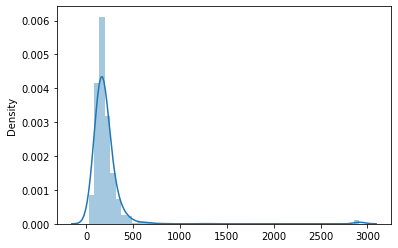

In [14]:
doc_lengths = []

for bio in text:
  
    # get rough token count distribution
    tokens = nltk.word_tokenize(bio[0])

    doc_lengths.append(len(tokens))

doc_lengths = np.array(doc_lengths)

sns.distplot(doc_lengths)
             

In [15]:
torch.cuda.empty_cache()

In [16]:
# tokenizer = GPT2Tokenizer.from_pretrained('gpt2', bos_token='<|startoftext|>', eos_token='<|endoftext|>', pad_token='<|pad|>') #gpt2-medium
tokenizer = AutoTokenizer.from_pretrained("microsoft/DialoGPT-small")
tokenizer.add_tokens(["<|patient|>", "<|doctor|>"], special_tokens=True)
model = AutoModelForCausalLM.from_pretrained("microsoft/DialoGPT-small")


Downloading:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/641 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/0.99M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/446k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/335M [00:00<?, ?B/s]

In [17]:
batch_size = 2
tokenizer.pad_token = tokenizer.eos_token

unique_vals = qa_df.id[len(qa_df)-1]

# Split into training and validation sets
train_size = int(0.75 * unique_vals)
val_size = int(0.125 * unique_vals)
test_size = unique_vals - train_size - val_size

train_split, val_split, test_split = split_data(qa_df, [train_size, val_size, test_size])

train_split.reset_index(drop=True, inplace=True)
val_split.reset_index(drop=True, inplace=True)
test_split.reset_index(drop=True, inplace=True)

train_split1 = train_split[0:int(len(train_split)/3)]
train_split2 = train_split[int(len(train_split)/3):2*int(len(train_split)/3)]
train_split3 = train_split[2*int(len(train_split)/3):]

print(len(train_split1))
print(len(train_split2))
print(len(train_split3))

# train_split1.to_pickle("/content/drive/MyDrive/CS685/splits/1.pickle")
# train_split2.to_pickle("/content/drive/MyDrive/CS685/splits/2.pickle")
# train_split3.to_pickle("/content/drive/MyDrive/CS685/splits/3.pickle")
# val_split.to_pickle("/content/drive/MyDrive/CS685/splits/4.pickle")
# test_split.to_pickle("/content/drive/MyDrive/CS685/splits/5.pickle")

print(train_split.head())

print("length of dataset: " + str(unique_vals))
print('{:>5,} training samples'.format(train_size))
print('{:>5,} validation samples'.format(val_size))
print('{:>5,} test samples'.format(test_size))

train_dataset = GPT2Dataset(train_split, tokenizer, max_length=768)
val_dataset = GPT2Dataset(val_split, tokenizer, max_length=768)
test_dataset = GPT2Dataset(test_split, tokenizer, max_length=768)

285
285
285
     id  ...                                               text
0   963  ...  [<|patient|>What is the suggested medicine for...
1   877  ...  [<|patient|>What causes problem problem in bre...
2   342  ...  [<|patient|>If I'm not sure if I have allergie...
3  1040  ...  [<|patient|>What could itchy small firm white ...
4   881  ...  [<|patient|>Suggest medication for sore throat...

[5 rows x 4 columns]
length of dataset: 1141
  855 training samples
  142 validation samples
  144 test samples


In [18]:
# Create the DataLoaders for our training and validation datasets.
# We'll take training samples in random order. 
train_dataloader = DataLoader(
            train_dataset,  # The training samples.
            sampler = RandomSampler(train_dataset), # Select batches randomly
            batch_size = batch_size # Trains with this batch size.
        )

# For validation the order doesn't matter, so we'll just read them sequentially.
validation_dataloader = DataLoader(
            val_dataset, # The validation samples.
            sampler = SequentialSampler(val_dataset), # Pull out batches sequentially.
            batch_size = batch_size # Evaluate with this batch size.
)

In [19]:
useCuda = True
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device)
print(device)

cpu


In [20]:
# I'm not really doing anything with the config buheret
# configuration = GPT2Config.from_pretrained('gpt2', output_hidden_states=False)

# instantiate the model
# model = GPT2LMHeadModel.from_pretrained("microsoft/DialoGPT-small")
# model = GPT2LMHeadModel.from_pretrained("gpt2", config=configuration)

# this step is necessary because I've added some tokens (bos_token, etc) to the embeddings
# otherwise the tokenizer and model tensors won't match up
model.resize_token_embeddings(len(tokenizer))

# Tell pytorch to run this model on the GPU.
# if torch.cuda.is_available() and useCuda:

# device = torch.device("cuda")
# model.cuda()

# Set the seed value all over the place to make this reproducible.
# seed_val = 42

# random.seed(seed_val)
# np.random.seed(seed_val)
# torch.manual_seed(seed_val)
# torch.cuda.manual_seed_all(seed_val)

Embedding(50259, 768)

In [16]:
# some parameters I cooked up that work reasonably well
epochs = 4
learning_rate = 5e-4
warmup_steps = 1e2
epsilon = 1e-8

# this produces sample output every 100 steps
sample_every = 100


In [17]:
# Note: AdamW is a class from the huggingface library (as opposed to pytorch) 
optimizer = AdamW(model.parameters(),
                  lr = learning_rate,
                  eps = epsilon
                )

In [18]:
# Total number of training steps is [number of batches] x [number of epochs]. 
# (Note that this is not the same as the number of training samples).
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler.
# This changes the learning rate as the training loop progresses
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = warmup_steps, 
                                            num_training_steps = total_steps)

In [19]:
total_t0 = time.time()

training_stats = []

model = model.to(device)

for epoch_i in range(0, epochs):

    # ========================================
    #               Training
    # ========================================

    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    t0 = time.time()

    total_train_loss = 0

    model.train()

    for step, batch in enumerate(train_dataloader):

        b_input_ids = batch[5].to(device)
        b_labels = batch[5].to(device)
        b_masks = batch[6].to(device)
        model.zero_grad()        

        outputs = model(b_input_ids,
                          labels=b_labels, 
                          attention_mask = b_masks,
                          token_type_ids=None
                        )

        loss = outputs[0]  

        batch_loss = loss.item()
        total_train_loss += batch_loss

        # Get sample every x batches.
        if step % sample_every == 0 and not step == 0:

            elapsed = format_time(time.time() - t0)
            print('  Batch {:>5,}  of  {:>5,}. Loss: {:>5,}.   Elapsed: {:}.'.format(step, len(train_dataloader), batch_loss, elapsed))

            model.eval()

            sample_outputs = model.generate(
                                    # bos_token_id=random.randint(1,30000),
                                    do_sample=True,   
                                    top_k=50, 
                                    min_length = 50,
                                    max_length = 200,
                                    # top_p=0.95, 
                                    num_return_sequences=1
                                )
            for i, sample_output in enumerate(sample_outputs):
                  print("{}: {}".format(i, tokenizer.decode(sample_output, skip_special_tokens=True)))
            
            model.train()

        loss.backward()

        optimizer.step()

        scheduler.step()

    # Calculate the average loss over all of the batches.
    avg_train_loss = total_train_loss / len(train_dataloader)       
    
    # Measure how long this epoch took.
    training_time = format_time(time.time() - t0)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epoch took: {:}".format(training_time))
        
    # ========================================
    #               Validation
    # ========================================

    print("")
    print("Running Validation...")

    t0 = time.time()

    model.eval()

    total_eval_loss = 0
    nb_eval_steps = 0

    # Evaluate data for one epoch
    for batch in validation_dataloader:
        
        b_input_ids = batch[5].to(device)
        b_labels = batch[5].to(device)
        b_masks = batch[6].to(device)
        
        with torch.no_grad():        

            outputs  = model(b_input_ids, 
#                            token_type_ids=None, 
                             attention_mask = b_masks,
                            labels=b_labels)
          
            loss = outputs[0]  
            
        batch_loss = loss.item()
        total_eval_loss += batch_loss     

        # if step % 1 == 0:

        #     elapsed = format_time(time.time() - t0)
        #     print('  Batch {:>5,}  of  {:>5,}. Loss: {:>5,}.   Elapsed: {:}.'.format(step, len(train_dataloader), batch_loss, elapsed))

        #     sample_outputs = model.generate(
        #                             # bos_token_id=random.randint(1,30000),
        #                             do_sample=True,   
        #                             top_k=50, 
        #                             min_length = 50,
        #                             max_length = 200,
        #                             top_p=0.95, 
        #                             num_return_sequences=1
        #                         )
        #     for i, sample_output in enumerate(sample_outputs):
        #           print("{}: {}".format(i, tokenizer.decode(sample_output, skip_special_tokens=True)))
               

    avg_val_loss = total_eval_loss / len(validation_dataloader)
    
    validation_time = format_time(time.time() - t0)    

    print("  Validation Loss: {0:.2f}".format(avg_val_loss))
    print("  Validation took: {:}".format(validation_time))

    # Record all statistics from this epoch.
    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Valid. Loss': avg_val_loss,
            'Training Time': training_time,
            'Validation Time': validation_time
        }
    )

print("")
print("Training complete!")
print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))



======== Epoch 1 / 4 ========
Training...


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   100  of    428. Loss: 1.9904370307922363.   Elapsed: 0:01:36.
0: :, 10,1,10,1,5,1,1,2,4,1,1,4,2,4,1,2,5,1,1,2,3,2,1,5,1,3,3,1,3,4,1,2,1,4,1,3,1,3,3,3,4,1,3,1,1,1,3,1,3,4,1,3,1,1,3,3,2,2,1,3,1,1,1


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   200  of    428. Loss: 0.8578883409500122.   Elapsed: 0:03:14.
0: It is also important that you are patient the following pregnancy if you need your doctor's permission. There is no serious concern for coronavirus risk, which in the case the risk of antibiotic treatment is high as well. As your current infection is likely to be cured, you need antibiotics to prevent infection infection.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   300  of    428. Loss: 1.6800845861434937.   Elapsed: 0:04:51.
0: ???? I went on a date with my husband from HCM. I had it down. I did not talk to him and it seemed weird when he called me. He said I was having a stroke but then the doctor prescribed a new card that I have not been given yet and gave me a call and told him that I was having an allergic reaction and he gave me two of the cards that were given to me. It just seems weird that I have such a strange reaction? Is it a medical issue or some type of respiratory disorder. Any history of asthma or something? What causes an allergic reaction in his eyes and mouth? Do I have to go to the doctor immediately? Any history of allergy or is it due to allergies/breathlessness etc. Or maybe pneumonia/not a severe case of allergic reaction/or something?


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   400  of    428. Loss: 1.2006853818893433.   Elapsed: 0:06:30.
0: Why does he have an x Ray on his face in the last picture? Last picture he has an X Ray on his face at the end of the month. He doesn't have an X Ray but it says he is using Oxycodone inhaler. So if he is using it it then he can not have an X Ray yet.

  Average training loss: 1.46
  Training epoch took: 0:06:58

Running Validation...
  Validation Loss: 0.96
  Validation took: 0:00:21

======== Epoch 2 / 4 ========
Training...


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   100  of    428. Loss: 0.6916390061378479.   Elapsed: 0:01:37.
0: Suggest remedy for allergic rhinitis in my neck and back? Hello I had an allergic rhinitis for over a week and now i can not sleep. My neck is hurting my heart. My body hurts from exertion. I feel more exhausted and more stiff than I do. Itchy in my neck. I have also been coughing and spitting mucus and saliva all day. I have been using prescription drugs for months. I have quit smoking since i was born. How long does it take to revert to normal when i cough up. Hi,                    


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   200  of    428. Loss: 0.6165674924850464.   Elapsed: 0:03:15.
0: What can cause severe coughing and difficulty breathing?What can cause severe coughing and difficulty breathing? HI,Thank you for providing the history of the coughing.I can only say the history of coughing and difficulty breathing were the last 4 days.Since now I have improved and it has been a long while that started again.Can you please tell me what is the last 4 days for the coughing. It is still present?   I have not developed any symptoms.  I would like to know more about this.    I have not slept for a while. I have no breathing difficulty and can feel my breathing is improving. It seems I have some symptoms.  I can not find any place to help you now. Please help.    If you have any further query, I would be glad to help you.If you are unable to find a chest consult you should start to consult another doctor for further guidance.  Would you like to video or text chat with me


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   300  of    428. Loss: 0.8655839562416077.   Elapsed: 0:04:55.
0: Will taking Corona B complex 10mg of Corona B complex 10mg of Corona B complex give me asthmatic fever?I am having mild asthmatic fever for 4 days now.  When I take it, does my asthmatic fever go away or do I have to take another drug?  My doctor says the combination is normal and he has advised me that I could be alright.  One thing is I need to know about my allergy, if the cough is severe. It's not a common allergy and I don't want to get it over, I do have asthma which causes me asthma problems. I am taking a drug though I am a kid and my mom has been in the facility since childhood.  My asthma is not a problem.  I do have a cough that is persistent and I am allergic to other substances.  I am a young adult. The drug may have been administered for childhood though I have tried others.   I should have investigated further and get


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   400  of    428. Loss: 2.2357161045074463.   Elapsed: 0:06:34.
0: Could be a strep throat?I have strep throat and have been in contact with a person with Covid 19 since Sept of 2016.  Could be a strep throat? Symptoms: Throat tightness, body aches, headache, and runny eyes. Throat tightness, body aches, headache and runny eyes. Throat tightness, body aches, headache, body ache. Symptoms: Throat tightness, headache, headache, body aches. Symptoms: Throat tightness, headache, body ache. Throat tightness, body ache. 

  Average training loss: 0.94
  Training epoch took: 0:07:03

Running Validation...
  Validation Loss: 0.92
  Validation took: 0:00:21

======== Epoch 3 / 4 ========
Training...


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   100  of    428. Loss: 0.4415791630744934.   Elapsed: 0:01:37.
0: My grandaughter is just a hiatal hiatal. Her history of heart problem was mentioned in the video description. She has had a heart transplant and has been admitted to hospital for a second round of antibiotics. But the heart transplant was planned at the beginning of the season. She has a history of heart problems and was admitted to hospital a second round of antibiotics. But the heart transplant was planned at the beginning of the season. She has a history of heart problems and was admitted to hospital a second round of antibiotics. But the heart transplant was planned at the beginning of the season. She has a history of heart problems and was admitted to hospital a second round of antibiotics. But the heart transplant was planned at the beginning of the season. She has a history of heart problems and was admitted to hospital a second round of antibiotics. But the heart transplant was planned at the beginning o

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   200  of    428. Loss: 1.055413007736206.   Elapsed: 0:03:16.
0: Hi there, I had been experiencing a dry cough for a couple weeks now. One or two times, I feel like my nose sometimes runs a little tight in the middle of the night (about 5-6 inches) and it starts becoming a bit wobbly. Do you think that may be due to my allergies? Thank you... Hello,Welcome to HCM,As you are having severe cough with a clear throat and a severe headache, it might be due to some infection.You may have a mild respiratory infection like upper respiratory tract infection which is more likely to occur due to allergy, and it has to be treated by your doctor, but as you are having the cough with clear throat you should see a doctor and ask what else you can do?Regards,Dr. Bhagyesh V. Patel, General Surgeon


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   300  of    428. Loss: 0.5863871574401855.   Elapsed: 0:04:55.
0: Is the coronavirus the correct choice for getting treatment for pneumonia?Hi. I'm a 59 year old man. I had pneumonia for a week on Sunday and I went to the hospital (where is the treating doctor? Is the coronavirus the correct choice for getting treatment for pneumonia? I'm a 59 year old man. I had pneumonia for a week on Sunday and I went to the hospital (where is the treating doctor? Hello, thanks for using healthcare magicIt may be viral but it is best advised to be examined in case of pneumonia.The coronavirus also might act as a permanent home for the patient.However, it depends upon severity of the pneumonia and other underlying cause.Things like allergic rhinitis may give rise to symptoms of pneumonia like dry cough and shortness of breath.If not it is best to consult a physician.As per Dr.Jolanda, the coronavirus may not act as a permanent home for the patient.Hope


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   400  of    428. Loss: 0.8355044722557068.   Elapsed: 0:06:35.
0: Have neck and back pain, neck pain but no pain in back. Why can I sleep for 7 days without feeling sick.  Have had 3 incidents of neck pain, no sore throat.  No fever.  Fever doesn't go down easily.   What could it be?  I have also been having headache since the beginning of the year.  My usual days are productive, but this time it feels worse.  I am feeling sick at work and have not been able to sleep.  Should I be worried? Thanks for your question on Healthcare Magic.I can understand your concern.As you are having chronic headache as well, there might be underlying respiratory tract infection.And a headache could be coming along with it.If I were the treating physician,I would do some test,i.e.e.g. a chest X-ray.Then I would know if it is right,but I still need some advise.I.e.e.e

  Average training loss: 0.77
  Training epoch took: 0:07:05

Running Validation...
  Validation Loss: 0.90
  Validation took: 0:0

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   100  of    428. Loss: 1.4446381330490112.   Elapsed: 0:01:37.
0: What causes bronchitis, bronchitis and runny nose while treating pneumonia?Hi there, my name is Brent. I am a 22 year old man. I have chest x-rays and a bronchoscope. I have asthma and I have cough from past two years. I have seen a lot of patients with bronchitis and have been to the doctor 4 times. Two of them were told they had type 1 diabetes and it turned into type 2 diabetes. Is this true? Hi Brent,Your history suggest that you are having allergic rhinitis, bronchitis and a high immune system.You should see your pulmonologist and PFT (Pulmonary Function Test). You will need inhaled cortico quinolones and inhaled corticosteroid (ICS) and inhaled cortico quinolones (formoterol or fluticasone).Don't worry, you will be alright with all these.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   200  of    428. Loss: 0.5501934885978699.   Elapsed: 0:03:16.
0: What causes sore throat, runny nose, sore throat/upper respiratory?I have a little sore throat and body aches. Initially, I thought it was a cold, but now I got cold, and I'm still sore. I can do a lot of things while coughing, and sometimes I have to do some breathing exercises that don't help. Hi, thanks for using healthcare magicItchy upper respiratory tract can lead to upper respiratory tract infection or common cold such as coughing,nasal blockage, bronchitis, laryngitis,  any malaise etc., So do not worry. You can use salbutamol and ibuprofen to cure that.I hope this helps


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   300  of    428. Loss: 0.300914466381073.   Elapsed: 0:04:55.
0: Suggest treatment for cough and shortness of breathHi i am a 14 year old female who suffers from cough and shortness of breath with slight nasal allergies. Symptoms as follows:1. First of all I would suggest you to consult a doctor to rule out COVID-192. After that a clear understanding about this can be reached and it can be decided very quickly if you are diagnosed with any abnormality like weight loss, shortness of breath, or anxiety.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   400  of    428. Loss: 0.7755762934684753.   Elapsed: 0:06:33.
0: Suggest treatment for pneumonia and COPDII have been in close contact with individuals with Pnemonia for 2 weeks, as well as individuals with Cavidurism and COPDI who now have an increased immune response to stimuli. Are these conditions likely to ever go away? How long will this problem continue to be exacerbated? My sister is now suffering from pneumonia and is having COPDI and her doctor has suggested a course of antibiotics with montelukast and inhalers. She has been taking Advair and Levaquin. Is there anything she can do to help? The only option is to wait it out. She needs to take another course of antibiotics  I am a 61 year old female. Thanks for your question on Healthcare Magic.I can understand your concern.Pneumonia means heart failure.Management involves:1. A course of antibiotics based on culture & sensitivity reports.2. Asthalin+ Seroflo inhaler- provide symptomatic relief

  Average training loss

In [20]:
# Display floats with two decimal places.
pd.set_option('precision', 2)

# Create a DataFrame from our training statistics.
df_stats = pd.DataFrame(data=training_stats)

# Use the 'epoch' as the row index.
df_stats = df_stats.set_index('epoch')

# A hack to force the column headers to wrap.
#df = df.style.set_table_styles([dict(selector="th",props=[('max-width', '70px')])])

# Display the table.
df_stats


,Training Loss,Valid. Loss,Training Time,Validation Time
epoch,,,,
1,1.46,0.96,0:06:58,0:00:21
2,0.94,0.92,0:07:03,0:00:21
3,0.77,0.90,0:07:05,0:00:21
4,0.64,0.93,0:07:03,0:00:21


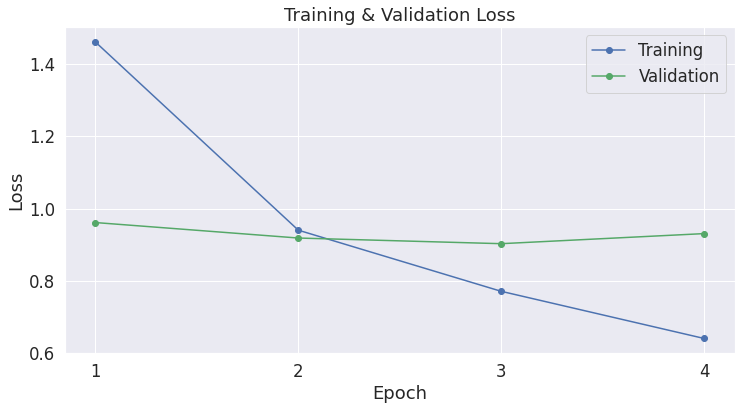

In [21]:
loss_curves(df_stats)

In [22]:
# Get all of the model's parameters as a list of tuples.
params = list(model.named_parameters())

print('The GPT-2 model has {:} different named parameters.\n'.format(len(params)))

print('==== Embedding Layer ====\n')

for p in params[0:2]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== First Transformer ====\n')

for p in params[2:14]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== Output Layer ====\n')

for p in params[-2:]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))
    

The GPT-2 model has 148 different named parameters.

==== Embedding Layer ====

transformer.wte.weight                                  (50259, 768)
transformer.wpe.weight                                   (1024, 768)

==== First Transformer ====

transformer.h.0.ln_1.weight                                   (768,)
transformer.h.0.ln_1.bias                                     (768,)
transformer.h.0.attn.c_attn.weight                       (768, 2304)
transformer.h.0.attn.c_attn.bias                             (2304,)
transformer.h.0.attn.c_proj.weight                        (768, 768)
transformer.h.0.attn.c_proj.bias                              (768,)
transformer.h.0.ln_2.weight                                   (768,)
transformer.h.0.ln_2.bias                                     (768,)
transformer.h.0.mlp.c_fc.weight                          (768, 3072)
transformer.h.0.mlp.c_fc.bias                                (3072,)
transformer.h.0.mlp.c_proj.weight                        (3072

In [23]:
# Saving best-practices: if you use defaults names for the model, you can reload it using from_pretrained()

output_dir = './models/decoder1/'

# Create output directory if needed
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

print("Saving model to %s" % output_dir)

# Save a trained model, configuration and tokenizer using `save_pretrained()`.
# They can then be reloaded using `from_pretrained()`
model_to_save = model.module if hasattr(model, 'module') else model  # Take care of distributed/parallel training
model_to_save.save_pretrained(output_dir)
tokenizer.save_pretrained(output_dir)

Saving model to ./models/decoder1/


('./models/decoder1/tokenizer_config.json',
 './models/decoder1/special_tokens_map.json',
 './models/decoder1/vocab.json',
 './models/decoder1/merges.txt',
 './models/decoder1/added_tokens.json',
 './models/decoder1/tokenizer.json')

In [21]:
tokenizer = AutoTokenizer.from_pretrained("models/decoder1")
model = AutoModelForCausalLM.from_pretrained("models/decoder1")
model.to(device)

GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(50259, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0): GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D()
          (c_proj): Conv1D()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
      (1): GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )


In [22]:
model = model.to('cpu')
rougeL = []
rougeLsum = []
rouge1 = []
rouge2 = []

test_dataset = GPT2Dataset(test_split, tokenizer, max_length=768, padding=False)
val_dataset = GPT2Dataset(val_split, tokenizer, max_length=768, padding=False)

f = open('decoder.csv','w')
f.write("input, prediction, ground\n")

for i, encoder_input in enumerate(val_dataset.input_ids):
    # print(type(encoder_input))
    # encoder_input = encoder_input[encoder_input != 50256]
    encoder_input = torch.reshape(encoder_input[0:-1], (1, -1))

    # predicted = model.generate(encoder_input, max_length=1000, min_length=50, return_dict=True)
    predicted = model.generate(encoder_input,
                            do_sample=True,   
                            top_k=50, 
                            # beam=5,
                            min_length = 50,
                            max_length = 1000,
                            top_p=0.95, 
                            return_dict=True
                          )

    decoded_input = tokenizer.decode(encoder_input[0], skip_special_tokens=True)
    decoded_prediction = tokenizer.decode(predicted[:, encoder_input.shape[-1]:][0], skip_special_tokens=True)
    decoded_ground = tokenizer.decode(test_dataset.decoder_ids[i], skip_special_tokens=True)
    
    print(decoded_input)
    # print("\n")
    print(decoded_prediction)
    # print("\n")
    print(decoded_ground)
    # print("How well did I answer the question? (See the five-point scale in the readme.)")
    # question_score = input("Answer: ")
    # print("Thanks! How fluent were my answers? (See the five-point scale in the readme.)")
    # fluency_score = input("Answer: ")
    print("\n")

    row = "\"" + decoded_input.replace("\"", "\'") + "\", \"" + decoded_prediction.replace("\"", "\'") + "\", \"" + decoded_ground.replace("\"", "\'") + "\"\n"
    # print(row)
    f.write(row)
    
    rouge_dict = rouge(decoded_prediction, decoded_ground)
    rougeL.append(rouge_dict["rougeL"])
    rougeLsum.append(rouge_dict["rougeLsum"])
    rouge1.append(rouge_dict["rouge1"])
    rouge2.append(rouge_dict["rouge2"])

f.close()

avg_rougeL_p = sum([rougeL[i].precision for i in range(len(rougeL))])/len(rougeL)
avg_rougeL_r = sum([rougeL[i].recall for i in range(len(rougeL))])/len(rougeL)
avg_rougeL_f = sum([rougeL[i].fmeasure for i in range(len(rougeL))])/len(rougeL)

avg_rougeLsum_p = sum([rougeLsum[i].precision for i in range(len(rougeLsum))])/len(rougeLsum)
avg_rougeLsum_r = sum([rougeLsum[i].recall for i in range(len(rougeLsum))])/len(rougeLsum)
avg_rougeLsum_f = sum([rougeLsum[i].fmeasure for i in range(len(rougeLsum))])/len(rougeLsum)

avg_rouge1_p = sum([rouge1[i].precision for i in range(len(rouge1))])/len(rouge1)
avg_rouge1_r = sum([rouge1[i].recall for i in range(len(rouge1))])/len(rouge1)
avg_rouge1_f = sum([rouge1[i].fmeasure for i in range(len(rouge1))])/len(rouge1)

avg_rouge2_p = sum([rouge2[i].precision for i in range(len(rouge2))])/len(rouge2)
avg_rouge2_r = sum([rouge2[i].recall for i in range(len(rouge2))])/len(rouge2)
avg_rouge2_f = sum([rouge2[i].fmeasure for i in range(len(rouge2))])/len(rouge2)

print("RougeL - precision: " + str(avg_rougeL_p) + ", recall: " + str(avg_rougeL_r) + ", fmeasure: " + str(avg_rougeL_f))
print("RougeLsum - precision: " + str(avg_rougeLsum_r) + ", recall: " + str(avg_rougeLsum_r) + ", fmeasure: " + str(avg_rougeLsum_f))
print("Rouge1 - precision: " + str(avg_rouge1_p) + ", recall: " + str(avg_rouge1_r) + ", fmeasure: " + str(avg_rouge1_f))
print("Rouge2 - precision: " + str(avg_rouge2_p) + ", recall: " + str(avg_rouge2_r) + ", fmeasure: " + str(avg_rouge2_f))

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


What are my chances of only getting mild symptoms if I get the virus, because I have type 1 diabetes?What are my chances of only getting mild symptoms if I get the virus, because I have type 1 diabetes? 
If you get the virus, you must not have traveled. The only way to cure your diabetes is by testing positive for covid-19, and staying at home and eating ice cream. Get well soon.
HI, sinus infection is secondary to  repeated common cold attacks getting secondary infection,if person has low resistance.    So, allergy being  one of  the instigating factor in repeated colds,may be blamed for sinusitis.    Yes one can be allergic to fabric/quilt dust fibers -inhaled & manifested as allergic rhinitis ( common cold)allergy.     You need to-        - get allergy testing, followed by avoiding allergens/ a desensatization treatment for removing allergy.        - have a nutritive diet,exercises,respiratory exercises,vitamin,iron,supplements( if advised by your doctor)        Thanks.




Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


What causes sharp pain in collar bone while coughing?I ve been treated for bronchitis and finished my z-pack today. Every time I courgh and breath deep there is a really sharp pain under my collarbone on the left side. I thought it might be pulled muscles but it s only on one side and really high up where no muscles are. Any advise would be helpful. Thank you I do have a pace maker in that area sss or sinus node syndrome Cassie L. FTW TX 
Hi, thanks for using healthcaremagic.comI have evaluated your query thoroughly.*  It is possible that the trauma to the collarbone may be due to infection of the heart with its compression of the back muscles due to the trauma to the sternum or shoulder blades.*      In either case, a chest x ray is needed.To confirm whether the pain is coming from either the chest itself or from the collarbone.If the pain is coming from the chest muscles then yes, chest pain can be treated with an x ray.Chest pain can be related to the injury of the neck/leg muscles.

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Why am I having choking feeling with throat pain?Hi, may I answer your health queries right now?  Please type your query here...I have been on inhaler Seroflo 250 twice and Xyzal tablet for quite some time after severe asthma.For last about 10 days,I have continuous throat pain and a feeling of swelling in the throat, though the cough has reduced a lot, whenever I cough I have a choking feeling and I really gasp for breath. The choking is very severe for 10 - 15 seconds and I can neither breathe in through the nose nor the mouth. It takes a minute or so to calm down to normalcy. 
Hi,Thank you for asking at HCM.I went through your history and would like to make suggestions for you as follows:1. Do you have any respiratory tract infection as well as chest pain?2. Do you have any respiratory tract infections other than pneumonia?3. Do you have any other chronic disease like pneumonia or common cold?4. Drink adequate amounts of water and take acetaminophen, ibuprofen if needed.5. Also, I w

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


What causes cold sensations in the abdomen and back while having pneumonia?My husband, age 63 is feeling cool on his abdomen and back while the rest of him is warm...currently sleeping. Last week was diagnosed with pneumonia...had a period last week when he was so cold, couldn t get warm so we went to the hospital. He says he is feeling fine and feels OK to work everyday (does construction work outside on a normal basis). Should I be concerned tonight that part of him feels cool even when under covera for an hour or two Thanks so much 
Hello,Thank you for asking at HCM.As per his history, he is having pneumonis.The pneumonia has been diagnosed by a chest xray and is likely to occur as the pneumonia is under medical control. The treatment may not be complete, but it does include antibiotics,antibiotics, antibiotics, bronchodilators, antihistaminics, antipyretics and mast cell stabilizers as prescribed by the doctor.Thank you.
In brief:   Covid-19 unlikely.   The usual infections in your

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


What will happen after the incubation period for covid 19?What will happen after the incubation period for covid 19? 
In brief:   There is a high level of COVID 19.    The goal is to have people who have traveled to high risk countries meet the criteria for testing and then go to meet the criteria for testing after the official test is confirmed. You will not have to wait much longer to get tested.   It is a long wait and even longer wait it is inevitable.  Would you like to video or text chat with me?
Hi thanks for your question.The big lump in along with several small lumps in the neck could be lymph nodes. Lymph nodes are normally present in body and get enlarged when there is infection in their vicinity. You are having sinusitis, upper respiratory tract infection and bronchitis. These lumps could be cervical lymph nodes. You are taking antibiotics along with plenty of symptomatic medicine. Continue with these medicines. But you a good physical examination along with investigations 

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


What risk am I from coronavirus as I have VTE?What risk am I from coronavirus as I have VTE? 
In brief:  Not necessarily  Not a risk         There are no direct precautions to prevent coronavirus but people in good health would not necessarily go to a testing centre to get screened.  Would you like to video or text chat with me?
In brief:   If bad, needs ER   COVID-19 pandemic at this time, so a doctor on video may consult by video instead of requiring an in-person visit.   Flu-like symptoms can be from a strep throat infection, a cold or influenza, or from some other cause like COVID-19. Usually, a person calls the doctor if the symptoms are bothersome, serious, recurrent, or persistent. COVID-19 testing depends on local availability. (3/22/20)  Would you like to video or text chat with me?




Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Does getting covid19 make you immune to a reinfection or just less likely to be reinfected?Does getting covid19 make you immune to a reinfection or just less likely to be reinfected? 
In brief:    Viral infectives.  Usually infections cause the reinfection, but most cases in the infectious areas tend to cause infection.   Usually, a person sees the doctor (call first) if the infection is bothersome, recurrent, or doesn't go away quickly.  Would you like to video or text chat with me?
In brief:   Yes and no.   Yes for the first question.   For the second question i should say no because the possibility of the store employee coming close less than 6 feet is great. But what you can do is you get out of the car open the truck and then call the store employee for a curb side pick up leaving always a 6 feet distance between two of you.  Would you like to video or text chat with me?




Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


What causes breathlessness and suffocation?recently about 5 months ago i have noticed that I have to take deep & long breathe after every 5 minutes,as such now last night before going to sleep,I got a smell of volini pain relief spray.after a few minutes I felt as if I am unable to breathe in,I tried to take deep breathe but then also I felt like suffocating.Can u plz tell me what it could be? 
HI! thanks for using health care magicThe most common cause for breathlessness and suffocating problems is breathlessness and suddenness of breath.It can be due to allergic reaction.This leads to a trigger factor of some respiratory system and will leads to breathlessness. This leads to breathlessness and will increase the chance of suffocating.The cough is so bad that it can never happen.The cough will resolve itself once the breathlessness subsides.In short, the breathing will be better.Hope I have solved your query. I will be happy to help you further. Wishing you good health. Thanks.
Hi,If y

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Painful abdomen, below chest, itching, tiredness. Is this normal?Hi sir,I am having a dull pain on the upper central abdomen just below the chest. Its been 2 weeks. I feel sort of pain and itchiness when i press with my finger on it. When i go for work i feel really tired,i dont feel like working at all.What could be the reasons?do i have to check with doctor and have some sort of test or its normal, 
Hello,Welcome to HCM,The symptoms as mentioned in your post can be attributed to an upper or lower respiratory tract infection.In either case, the above symptoms are not indicating an infection. You should consult pulmonologist for a thorough clinical examination with sputum examination to rule out an infection. You may need bronchoscopy (Pulmonary X-ray) to rule out strep.You may also need bronchodilators (formoterol or salmeterol) as a treatment.A course of antibiotics (formoterol or salmeterol) with anti biotics (quinolones or macrolides group) will be helpful. You may also use anti hi

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


What are the signs and symptoms of pneumonia or pertussis?How can one be sure of a diagnosis of pneumonia or pertusses in adults. How do you compare? My doc thinks I have pertusses. But the doctor in Mexico where I was originally treated said I had PB pneumonia. I was on intravenous antibiotics for three days in Mexico before coming home to my dr.here in L.A.The xrays showed lots of mucus in my lungs.  I am confused.  is there a definitive test for petusses in adults? Dr said I will be fine. Gave me ADVAIR and cough medicine and says I will be fine but will cough for a pretty long while until the lungs are clear.  He said I do not need antibiotics because I have already had zpack and 10 days of ampicillin, and then 3 days fo intravenous antibiotics. Who do I believe? I am 65 years old. never was feeling this sick or tired before or have had any kind of lung involvement in my life.  I am a strong healthy woman. No immune deficiency or anything like that. 
Thank you doctor,Your pneumonia

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Can Covid-19 be transmitted sexually? Can any coronavirus be transmitted sexually?Can Covid-19 be transmitted sexually? Can any coronavirus be transmitted sexually? 
In brief:  Coronavirus.  In our current climate, we are expecting more of the same with current cell strains. I don't think it's necessary to keep this confidential as much as possible.   Would you like to video or text chat with me?
Hello, Usually, he is contagious one week before treatment and until three days after treatment. Hope I have answered your query. Let me know if I can assist you further. Take care Regards,Dr Jnikolla, Pulmonologist




Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


I have all the symptoms except fever, I went to Medicross and Dr said I can get tested if I want to I'm not sure if I should. She gave me antibiotics Klacid XL 500mg, she said I can take it if I feel worse I'm worried it will make immune system bad?I have all the symptoms except fever, I went to Medicross and Dr said I can get tested if I want to I'm not sure if I should. She gave me antibiotics Klacid XL 500mg, she said I can take it if I feel worse I'm worried it will make immune system bad? 
In brief:    Hello,Welcome to Healthcaremagic.comI can understand your concern.In my opinion, you should consult a doctor for clinical evaluation and then do a follow up. A chest x-ray is required to rule out viral or bacterial infections.So, you should consult with a respiratory specialist for a proper clinical evaluation and then follow through.Hope this information helps you.If you have additional questions or follow up questions, you can contact me on the below link:bit.ly/dr-srikanth-srikan

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


How to differentiate between angina and asthma?I was just released from the hospital after having the "fish" procedure done.  I was diagnosed with angina (I had a three day stay and lots of tests run) but when I went to the health department to get a note to return to work was told that i dont have angina I have asthma and was put on two seperate inhalers even though the health department ran no tests.  Who do I believe? 
hello,Angina is considered a mild angina but can be triggered by multiple factors like allergies/obstruction etc.Angina could be triggered by skin irritants/feces etc.If your symptoms are mild, you would not need to worry much about it.Asthma is the most common cause of your symptoms.Management involves:1. A course of antibiotics based on culture & sensitivity reports.2. Asthalin & Seroflo inhaler- provide symptomatic relief by causing broncho-dilation (dilating the smaller airway passages, relieving the obstruction & increasing airflow to lungs)So, you can use it whe

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


I am a 46 year old female. I've had Trach for the last 9 months due to stridor, bronchospasm and larageal spasms. I am currently being worked up for autoimmune disease. I am on Xoliar am I more susceptible to coronavirus?I am a 46 year old female. I've had Trach for the last 9 months due to stridor, bronchospasm and larageal spasms. I am currently being worked up for autoimmune disease. I am on Xoliar am I more susceptible to coronavirus? 
In brief:  Covid-19      As you explain the history, no worries.   I would not think of you as a high risk person in this situation. It sounds like you are in good hands with other medical conditions, as you are in close contact. I would recommend taking a deep breath, taking antibiotics (quinolones preferred), antibiotics (quinolones preferred), and other symptomatic treatment.  Would you like to video or text chat with me?
Bacterial likely. Use nasal saline rinses, a nasal steroid and discuss the use of Augmentin for 10 days with your PCP. It is mo

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Having type 1 diabetes, doesn’t mean you have low immunity does it? So what is it about it, that makes us more at risk with the virus?Having type 1 diabetes, doesn’t mean you have low immunity does it? So what is it about it, that makes us more at risk with the virus? 
Probably not. If you get diagnosed with either COVID 19, you are most at greater risk for COVID-19.
Hi,All this symptoms could be because of upper respiratory infection (pharyngitis, laryngitis, epiglotitis) or bronchitis or allergic rhinitis or sinusitis.It is mostly due to viral infection like EB virus,adenovirus but some time could be bacterial or parasitic.You may have some routine blood investigation with sputum tests as you had cough since 2 months and Chest X- ray to get diagnosed first.You may require higher antibiotics (quinolones or macrolides) to prevent superinfection with antiinflammatory and other supportive treatment like bronchodilators if there is any breathing problem.It would be advisable to see pulmon

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


What causes constant arm pain with respiratory infection?I was just wondering if I should be concerned if I had a upper respiratory infection for a few days as the symptoms subsided I am left with constant arm pain on both hands it has been three days now I have taken ibuprofen, Celebrex to subside pain (heat, ice )starts at the wrist up to both shoulders I thought it was the antibiotics I was taken but it has yet to have any relief what should I do 
Hi!Your symptoms are suggestive of a upper respiratory infection.So better to consult your doctor for complete blood count, serum IgE levels, blood sugar count and total IgE levels. Also get yourself evaluated as per normal clinical guidelines. I hope this helps
In brief:   Cough and cold   Hello and welcome to HealthTap,It is a good idea to get tested.   You can visit your nearest Urgent care. Make sure to call them before coming, after getting tested self quarantine for total 2 weeks from the onset of symptoms. Please wear mask and perfo

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


I have diarrhea and I read that it could be a precursor to having COVID-19. I was in China end of September 2020. So more than 6 weeks back.?I have diarrhea and I read that it could be a precursor to having COVID-19. I was in China end of September 2020. So more than 6 weeks back.? 
In brief:   Quarantine.  You can have a covid 19 test if symptom free (not sick, pneumonia or the flu). If the test is positive, then you should go to your doctor to get tested.  If your symptoms worsen and you get fever, you should have a report. Would you like to video or text chat with me?
Dizziness. Yes. Please contact your doctor since they know you better. He may want to test you for the virus. There are other reasons you may be dizzy as well..




Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


What are the symptoms and treatment for pneumonia?I have been ill for 6 weeks and my GP suspected pneumonia and I was put on antibiotics.  The third one has almost cleared the infection.  However, I had an X-ray and it apparently showed nothing at all, although all my symptoms were in line with pneumonia and my GP had definitely heard a lot of crackles in the left lung.  Is it possible that I had pneumonia if the Xray was clear? 
HI, thanks for using healthcare magicThe most common causes of pneumonia are infection of the respiratory tract (inflammation of the airway, obstruction of the lung), and infections of the lung can spread to lung.Management involves:1. A course of antibiotics to eradicate all the causative organism.2. Asthalin & Seroflo inhaler- provide symptomatic relief by causing broncho-dilation (dilating the smaller airway passages, relieving the obstruction & increasing airflow to lungs). So, I would think of course bronchodilators and antiinflammatory drugs like Cetrizi

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Suggest home remedy for respiratory problem due to allergyI am suffering from allergy some respiratory problem during early day time. From time to time during night hours there is coughing due to which continuous sleeping is disturbed. I am also suffering from HT.  Is there is any natural course which give me relief then it will be nice of you SIR. 
hi, thanks for using Healthcaremagic.comI have reviewed your query and here is my advice.I would like to convey my opinion as follows:1. Yes, it is possible that some allergic person might have respiratory tract infection (common cold), so avoid all medications unless diagnosed by the doctor.2. As you have mentioned, it could be a common cold (usually not an upper respiratory tract infection), and also could be bronchitis or pneumonia.You should get done repeat chest x-ray (quinolones or cephalosporins) to rule out any allergic reaction.3. Personally, I would suggest you to take medicines like ibuprofen and montelukast (fluticasone or cetri

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Headache, enlarged abdomen. CXR showed prominence of hilar lymph nodes. Want opinionhi sir im a resident physician, we have this clinicopathologic conference case here, i would just like to ask your opinio with our case...hope you can help us with the diagnosis and differentials.... General Data This is a case of a 27 year old female, single, Catholic from Samar, admitted for the first time due to severe throbbing headaches and enlargement of the abdomen. History of Present Illness Condition started 8 months PTA, when she suddenly felt severe throbbing headaches while lying down, occurring alternately between the right and left sides of the head, lasting approximately an hour with associated nausea. The pain would be slightly relieved by Paracetamol. This was also associated with blurring of vision. The patient was noted to have light perception, but other figures were described as “cloudy”. There was also notable enlargement of the abdomen prior to headaches, no change in the frequenc

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Causes for a bright red circle around the anus for a person already suffering from exezma?My 4 year old daughter has a bright red circle around her anus. It's not iching and really she hasn't said much about it hurting her but it's super red. No bumps just smooth kinda. It's been day 2 and last night I put cream on it but nothing changed maybe even worse. She has been bad with allergies lately and been using her breathing treatment. She has exezma as well. What could this be I'mWorried bc it's very red and large covering the whole butt hole. Thanks 
HI, thanks for using healthcare magicThe symptoms as mentioned in your post can be attributed to acute exacerbation of asthma, secondary to the respiratory tract infection.Management involves:1. A course of antibiotics to eradicate the causative organism.2. Asthalin+ Seroflo inhaler- provide symptomatic relief by causing broncho-dilation (dilating the smaller airway passages, relieving the obstruction & increasing airflow to lungs)So, it ca

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Symptoms include irritation in the throat, dry cough, trouble breathing properly, headache. However not really a sign of a fever. Temperature is about 35 degrees. Should I get tested?Symptoms include irritation in the throat, dry cough, trouble breathing properly, headache. However not really a sign of a fever. Temperature is about 35 degrees. Should I get tested? 
In brief:   Hard to say  If your fever is not severe, you should not develop symptoms.       Usually only the  symptoms are more severe in cold weather.    Would you like to video or text chat with me?
this teriible cough may be due to respiratory infection may be due to acceleted hypertension or something else..you should consult your physician before taking any decision




Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Should I stay away from my family if I still have to work during the pandemic? I deliver beer to grocery stores and gas stations.. and I’ve been worried about possibly getting it and then them catching it.. since they said you can be asymptotic..Should I stay away from my family if I still have to work during the pandemic? I deliver beer to grocery stores and gas stations.. and I’ve been worried about possibly getting it and then them catching it.. since they said you can be asymptotic.. 
Protection from the Corona virus is advised. Travel in a positive environment, drink adequate fluids, wash hands frequently, avoid touching your face and nose. If you develop fever and diarrhea, consult your doctor.
Get meds refilled. With the COVID-19 pandemic, people with chronic conditions or even intermittent conditions should get their meds refilled in case pharmacy services close down. For asthma patients, they should refill their inhalers. Some use only an urgent "rescue" inhaler like albuterol

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


I have a dizzy head and some phlegm. Need to check against Covid symptoms please?I have a dizzy head and some phlegm. Need to check against Covid symptoms please? 
In brief:     Covid     Covid      Stay home. Try to isolate.  Stay safe.   Would you like to video or text chat with me?
In brief:   Nearly normal   Assuming you are not on any immunosuppresive therapy your risk is normal.   but make sure you do social distancing  Would you like to video or text chat with me?




Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


What causes wheezing sound from chest during weather change with pneumonia history?my son got severe pnemonia last year and was hospitalized after that whenever there is a weather change he gets wheezing sound frm his chest. does that indicate he has bronchities?? or any allergy? doctor told me to start myteka course for six months. will it eliminate his problem?? 
Yes, you can continue your antibiotic. Also make sure that he doesn't get any other symptoms, other chronic illnesses tend to have similar symptoms.
In brief:   It depends.   It depends of your country and the state of coronavirus, in some places you need to have traveled recently to another country to get the test, and in another countrys you need to be tested right away after any symptoms.   You should check your country  phase of coronavirus  Would you like to video or text chat with me?




Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Sick for past week. Doctor prescribed meds. Not feeling better. Symptoms are shortness of breath, difficulty breathing, barking cough, mild headache, body ache. Should I consider getting tested for Covid 19.Sick for past week. Doctor prescribed meds. Not feeling better. Symptoms are shortness of breath, difficulty breathing, barking cough, mild headache, body ache. Should I consider getting tested for Covid 19. 
In brief:         Covid can’t see your symptoms  He may be able to see what you are going through  (if that is possible)   Would you like to video or text chat with me?
It depends... Due to limited availability of covid testing, you probably wouldn’t meet criteria for testing, unless you develop fever or cough, and you have chronic health problems or have been possibly exposed to covid.Seek care right away if difficulty breathing or severe symptoms.Seek online or phone consultation otherwise, to avoid exposure.Ultimately, patients who need treatment will have lung symptoms.




Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


21 month old has a fever 38.7 and dry cough?21 month old has a fever 38.7 and dry cough? 
In brief:  Stay home.    Travel Isolate 14 days from COVID-19  Would you like to video or text chat with me?
Hello.Thank you for asking at HCM.I went through your son's history. Getting out of breath can be a symptom of both heart and respiratory disease. But if your son already has asthma, breathlessness/wheezing after exercise/sports suggests what we call "exercise-induced bronchospasm". Usually it means your son's asthma is not under adequate control and he needs to upgrade his controller asthma medications. Personally I would suggest adding montelukast for asthma control which works better in this type of symptoms.I would also suggest him to take an inhaler like salbutamol or levosalbutamol 20 minutes before starting exercise/playing. Or he can take a tablet montelukast 30 minutes before exercise/play. Also, have a slow warm-up like walking/jogging for 5-10 minutes around half-an-hour before s

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


I am a pregnant pharmacist working in a government hospital. I am in my third trimester. Should I take leave until my maternity leave starts due to the coronavirus pandemic? Government has not made any recommendations for pregnant healthcare workersI am a pregnant pharmacist working in a government hospital. I am in my third trimester. Should I take leave until my maternity leave starts due to the coronavirus pandemic? Government has not made any recommendations for pregnant healthcare workers 
COVID-19 infection. At 33 your wife has become so ill that if your wife is still having cough or difficulty breathing then you are out of options. The coronavirus pandemic is not related to pregnancy. It is a viral infection. So stay home.
In brief:   Yes    like most lung infections there will be changes in the lung structure, probably microscopically and may not be seen on X-rays,  Would you like to video or text chat with me?




Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


What is the cause of deflated scrotum?I have a handicapped son 13 and sick with a respiratory infection....possibly dehydrated...saw dr yesterday..today his scrotum seems??? deflated.. some thing is different can illness and dehydration cause this? He is tube fed and has a tracheostomy. started z-pac and increased H 2O 
Hello,As per your post infection is mostly due to diffuse inflammation of the space between the tracheostomy tube and the esophagus of the esophagus and the tracheo tube.It can also be due to bacterial infection.But this is most commonly a bacterial infection.Hope I have answered your query. Let me know if I can assist you further.Regards,Dr.Raveendran
In brief:   Cough/fever?   Please stay at home and avoid contact with others for one more day at least.   If there is a fever, remain at home for at least three days after the fever is gone. At this point, if you are otherwise healthy, cover your cough, monitor your temperature and please stay home.Watch for signs of seco

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


How to cure abdominal pain in kids?My 7 year old son has been complaining of abdominal pain in the last month. Last week he had a red spotty rash all over his legs. Dr did a urine strip test which showed Protein. This was sent for pathology testing which showed Protein and Red Blood Cells. Another strip test was done yesterday by the Dr which showed Protein and Ketones. This has also been sent to pathology. His abdomonal still persists. 
Hello,Welcome to HCM,The protein deficiency in the leg can cause irritation to the tissues of the affected region and the tissues of the tissues of the affected tissues of the affected region will produce the symptoms, including itching, soreness, constipation, fatigue and blood clots.These causes can occur after taking the antibiotic, which will help prevent the bleeding of the affected tissues.If the deficiency still persists, you should visit your pediatrician for a chest x-ray.He will be receiving the antibiotics which will be helpful in preventing

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Is constant chest infection and coughing sign of pneumonia?I have had constant chest inf was hospitalised for 4 days said they think phnewmonia out now still on lots of anti biotics and steroids however I'm still sweating have right lower back pain and still really coughing and short of breath. I am MBL deficency and alpha 1 
Hello and Welcome to ‘Ask A Doctor’ service. I have reviewed your query and here is my advice. *  It looks like your pneumonia is developing at an alarming rate.  Please complete your protocol for complete antibiotic treatment, and get your symptoms under control. *  Thanks for using HealthcaremagicIf you are in the United States, please consult with your Primary care Physician and get instructions.You must first get diagnosed with pneumonia, then get a chest x-ray to rule out any infection, then get an x-ray to rule out upper respiratory infection.Hope this helps
Probably. We should all be cautious, not worried about Covid-19. It is prudent for us all to be socia

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Does exposure to black mold cause asthma, chronic URI s and weakness?My friend was exposed to airborn black mold a few years ago initally she started c sinus infections c sores inside the nose & feeling flu-like, then she developed asthma & chronic URI s then numbness, tingling shooting pain & weakness in BUE which led to all-over weakness & now she has recently been DX c Divic s (spelling is wrong) it s got to do with optic neuritis & partial loss of sight in the L eye: & the L side of her body esp LLE is weak originally the Doc s thought she had MS but now think it s the Divic s & the pognosis c this disease is very poor, plus she has elevated protien in the blood & spinal fluid & she thinks that she may have this CIDP R/T prolonged exposure to this airborn black mold? What are the chances that this exposure is the cause of her illness now? 
Hi, thanks for using healthcare magicIt appears to be a viral disease of the respiratory system.She may have had exposure to it.It might also be

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


My 2year old Son has had a dry cough and a runny nose since thursday. He's not talking yet so it is difficult to tell if he has any trouble breathing so I'm concerned. He does not have temperature?My 2year old Son has had a dry cough and a runny nose since thursday. He's not talking yet so it is difficult to tell if he has any trouble breathing so I'm concerned. He does not have temperature? 
No. Covid19. There are many causes and risks for children who cough for a period of time. If you have any respiratory illnesses, cough with sputum fever and cough with fever, expectorant bronchitis or influenza (Bactocidazobium). These may be considered common among children. It is very difficult to predict the cause of Covid19. If you are otherwise in good hands, you could ask your pediatrician for instructions.
hi,thank you for providing the brief history of you.As you have tonsilitis and coughing there will be an expected pain in the rib cage due to excessive exertion happening by muscles in co

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Are frequent nose bleeds and sever cough signs of pneumonia?I've been recently having more nose bleeds lately. 4-5 times per day to be exact. And I have the worst cough ever that comes with it. Even when I am asleep my nose starts to bleed and I wake up due to the blood running down my mouth. Is this pneumonia?! Or some other illness? 
Hello,Welcome to ‘Ask A Doctor’ service. I have reviewed your query and here is my advice.You might be having upper respiratory tract infection (URTI). I would suggest you to get a chest x-ray done to rule out any pathology.You may need antibiotics (quinolones or macrolides) with decongestants and anti histamines (like Cetrizine or salbutamol) with analgesics as well as antiinflammatory and/or alternatively you may consider undergoing routine blood investigations and X-ray chest with sputum examination to rule out any pathology.Hope this information will help you to make suggestions for you further management of your symptoms.If you have any further quer

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


How can I reduce allergic reaction in form of hives?i had an allergic reaction in the form of hives mainly around my ears and neck area With this am can feel pain when i try to swallow water or food i could also see that there are a lot of slim forming in my throat It is as if this slime are causing the pain when i am swallowing i am constantly  tiered having problems with sleeping since it is uselly when i ly down when i feel worse 
Hello dear,The symptoms as mentioned in your post can be attributed to the following:1. A course of antibiotics based on culture & sensitivity reports.2. Asthalin & Seroflo inhaler- provide symptomatic relief by causing broncho-dilation (dilating the smaller airway passages, relieving the obstruction & increasing airflow to lungs).3. Montelukast preparations- used to provide symptomatic relief from cough & runny nose.4. Antihistamines can also be used to provide symptomatic relief.5. Steam inhalation & deep breathing exercises will help you in achieving th

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Is it safe to take steroid tab or nasal spray if I have covid-19?Is it safe to take steroid tab or nasal spray if I have covid-19? 
In brief:     Throat pain can be from a strep throat infection to a cold or influenza.   Usually a person sees the doctor if the strep throat is bothersome, recurrent, or doesn't go away quickly, particularly at night. A person sees the doctor if the strep throat is bothersome, recurrent, or doesn't go away quickly, particularly at night.   It can be from a strep throat infection to a cold or influenza, or from a person sees the doctor if the strep throat is bothersome, recurrent, or doesn't go away quickly, particularly at night.   If the strep throat is bothersome, or doesn't go away quickly, especially at night, call the doctor.  If you don't have access to testing, or have travel to high risk areas, or if you've traveled internationally or been in facility treating people with Covid-19, or been in facility treating people with the virus, you might have

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


How can pneumonia, coughing with low body temperature be treated?Hi, may I answer your health queries right now?  Please type your query here...I am 42 year old female with known case of pneumonia and constant coughing and low body temp of 35.3c  feeling anemic advise please? currently using Bioxin and guafinicine/codein 
Hi, you are right now.The above query is very correct. You should be aware that the pneumonia is from many reasons related to respiratory tract infection.Most of the time it does not cause pneumonia. However, you need not worry if you have been exposed to any serious illness which is why you should take antibiotics and antihistamines with other medication as you don't have flu like other illnesses. Hope I have answered your query. Let me know if I can assist you further. Regards,Dr Shareef
You have not cleared what type of stomach disease he has. It's simple pain in stomach or nausea etc or shooting pain or diarrhoea. However any general physician can set it right and

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


What is the dosage of Asthalin during pregnancy?i am pregrant with twins, and now in 22 week, i have asthama problem, i have taken Asthalin inhealer 2 times last night. still it feel breathing problem, is there any restricition to take Asthalin inhealer at this point of time, any restricition on any number of times it shouls take? 
Hello,Asthalin is the safest prognol for respiratory distress in pregnancy. The symptoms as mentioned in your post can be attributed to acute exacerbation of the symptoms of bronchospasm of bronchospasm (obstruction of smaller airway passages, secondary to the respiratory tract infection. The use of a decongestant will be helpful for your symptoms. Hope I have answered your query. Let me know if I can assist you further. Regards,Dr. B. S MBBS
Hello dearWarm welcome to Healthcaremagic.comI have evaluated your query thoroughly.*  There are different  reasons  for this as    -  lung abscess -  effusion  -  cardiac  distress induced  -  lung hypoxia     due  to 

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


What are the side effects of budecort and does mucous regulators have more side effects than nebulized alternatives?In the past 6 months My son has had multiple instances of bronchitis related issues where he wheezes and then his Paed puts him on Bricarex A + Ambrodil XP with Budecort 0.5 + Levolin 0.3 nebulization. The condition does improve a lot after 5-6 days of active treatment using this combo. Wanted to know: a) The side effects of Budecort (Budesonide) (Cortocosteroid type inhaler for 3-4 yr old. b) Whether Oral expectorant and bronchodilators or mucous regulators have more side effects and dangerous than nebulized alternatives. 
Budesonide is generally safe and effective in respiratory system (but often causes bronchitis,diseases,dilating the smaller airway passages,dilating the smaller airways,dilating the smaller airways, and causing sedation and shortness of breath, and therefore causing rapid expansion of the lung. However, it is a very effective drug that can only be used

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


What causes chest pain during pregnancy?hi im 21yrs old and 28weeks pregnant and keep getting chest pain, its really tight and hurts, i cant breath with it and am also sick, it usually lasts 20-30mins and its also been waking me up at night, my bump goes really stiff and doesnt like it, its not heart burn or trapped gas, i also have low blood pressure and am oftern dizzy and faint can you help?? should i be worried or ignore it? 
Hello dear,The symptoms as mentioned in your post can be attributed to Acute exacerbation of bronchial asthma.Management consists of:1. A course of antibiotics to eradicate the causative organism.2. Asthalin+ Seroflo inhaler- provide symptomatic relief by causing broncho-dilation (dilating the smaller airway passages, relieving the obstruction & increasing airflow to lungs).So, it can be used during an acute attack.3. Montelukast preparations- used as a maintenance therapy to relieve symptoms of asthma.4. Antihistamine & anti-inflammatory supplements to provid

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


What is the best home remedy for breathing trouble in lyme disease patient?In September my husband was diagnosed with Lyme Disease, which we have learned causes respiratory problems, among other things. Beforehand he was diagnosed with COPD & Emphysema, he is prescribed Symbicort & Spiriva for these conditions. We are located in WV and at this time are having extremely cold temps. and he is having severe trouble breathing is there anything you can suggest we do at home to help his breathing in addition to the medications he is already taking? I understand the emergency room is available for emergency services but at this time driving conditions are very hazardous, if you have any suggestions short of a trip out to the emergency room, they would be so very greatly appreciated. Thank you so much! 
Hello and Welcome to ‘Ask A Doctor’ service.I have reviewed your query and here is my advice. Yes, you are correct in some cases.In some patients with allergic conditions there is a need for br

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


I am 63 living in Jhb and have had a tight chest and sore throat and wet cough for more than a week?I am 63 living in Jhb and have had a tight chest and sore throat and wet cough for more than a week? 
In brief:   No  No  No worries   The current NICD guidelines are to stay at home for 14 days if possible with supervision.     Stay in social distancing, rest and drink fluids, wash hands frequently, cover face with mask, cover mouth with mask mask and disinfect everything unless required.  Would you like to video or text chat with me?
Hello.Thank you for asking at HCM.I went through your child's history and would like to make following suggestions for you:1. I would like to know more about your daughter's symptoms - how many attacks of asthma she has had so far? What is her current age? Do you smoke otherwise, if not around your child or in home? How severe her asthma is? Did she require admission?Based on these details, I would be able to help you better.2. In fact childhood asthma is 

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Hi  I am a doctor working in a state hospital.  I have malaise, headache and a sore throat now for a week. My left eye also had conjunctivitis but the other symptoms do not resolve.   There is a covid 19 contact in our estate.   Should I test for it?Hi  I am a doctor working in a state hospital.  I have malaise, headache and a sore throat now for a week. My left eye also had conjunctivitis but the other symptoms do not resolve.   There is a covid 19 contact in our estate.   Should I test for it? 
In brief:  Covid 19 is a rare form of viral infection so don't worry about testing for it. If sick or possibly exposed call your local health resources for instructions on testing.   Would you like to video or text chat with me?
Real vs. textbook. Real-life criteria is different because we don't have enough tests, supplies, or medical staff around the world at this time (March 2020). Textbook criteria are suspected COVID in hospitalized persons or in those with underlying medical conditions; o

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Should I see doctor for my daughter who has runny nose and cough?My 2 year old daughter who weighs about 23 pounds. Has had a green runny nose for about 2 weeks, and a cough as well that occasionally will make her cough so bad she will vomit. Now she has a temperature of 99.6 which I know isn t too high, but I m just concerned because she doesn t seem to be getting better. Could this be a cold or allergies, we recently had a warm spell and the pollen was quite high, and should I call her doctor by now since its been so long, or wait it out? 
Hello,Welcome to HCM,A few days ago,Symptoms could be due to Acute COVID-19 and COVID-19.Symptoms could be different.It appears like COVID-19 is the most common cause of fever and cough.Symptoms like shortness of breath, irregular heartbeat, nausea or a wet nose could be because of an upper respiratory tract infection, as well as the coughing could be due to some other cause.Symptoms of the fever or cough could also be due to allergic rhinitis and 

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


whats the treatment for alleric asthma?i get difficulties in breathing when i inhale fumes and dust and when humidity is very high.what is the possible treatment and the cause.am 57 n i have no treatment 
Hi, thanks for using healthcare magicFor asthma the respiratory tree is called Acute exacerbation of asthma.The management consists of:1. A course of antibiotics based on culture & sensitivity reports.2. Asthalin+ Seroflo inhaler- provide symptomatic relief by causing broncho-dilation (dilating the smaller airway passages, relieving the obstruction & increasing airflow to lungs)So, it will be better to use inhalers for symptomatic relief.3. Montelukast preparations- used as a maintenance therapy to relieve symptoms of asthma.4. Antihistamines like Cetrizine can also be used to provide symptomatic relief.5. Steam inhalation will also help.6. Also make sure that you are well protected from exposure to cold, dust or other allergens.If symptoms still persist, kindly consult a Pulmonologis

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


What causes deep breathing to my 7year old?My 7 year old daughter has been taking deep breaths. It happens even while at rest. She will ask me how do you breath? She doesn t have respiratory problems. She will take a deep breath every 30 seconds. It s not all day, just random times of the day/night. 
Hi,I had gone through your query and understand your concern.From what you explain, deep breathing has become habitual for her.Inhaling breathless and then gradually increasing her heart rate and breathing difficulty can cause difficulty in breathing.If she worsens to this occurrence (usually heart attack) or if she develops a respiratory attack or dizziness (sore throat ) her heart rate is fine.Do regular breathing exercises while waiting for her to breath, chest X-rays and ultrasound are advised.If symptoms develop more gradually,she should be examined by a Cardiologist (cardiologist) by video or phone.She should also be physically examined by a Cardiologist if they can assist with makin

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Which is the best exercise in year following treatment with levofloxacin for pneumonia?What is the advisability of exercise in the year following treatment with Levofloxaxin for pneumonia? I just completed 5 days of treatment with pills after 4 or more days of IV in the hospital following gall bladder surgery. I entered the hospital with pneumonia (not knowing I had it), probably having contracted it from my brother who had it and whom I had visited several days earlier in another hospital. I am 71 years old, female; I had a non-heart damaging heart attack in 2003 and have tried to maintain a good exercise program to lessen my chances of worsening heart disease. Should I resume Naproxen for joint/muscle pain; had 2 doses (2 tablets twice daily) 2 days before hospitalization. Did not need it the 3rd day and was hospitalized the next day. Did not take it post hospitalization. Do not remember if they gave it in hospital; think not. Thank you. 
In brief:                                    

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


A 2 year complaining that his head is sore. We gave him panado in the morning and at midday. He can't sleep he keeps waking up crying its painful. Should I take him to a Dr or hospital?A 2 year complaining that his head is sore. We gave him panado in the morning and at midday. He can't sleep he keeps waking up crying its painful. Should I take him to a Dr or hospital? 
Cortisone deficiency. Shortness of breath and chest discomfort are signs of a fever and abdominal pain. Your doctor should consider consulting a physician for fever, hypertension, and other symptomatic treatment. For your fever, consult pulmonologist and get done blood work and chest x- ray done if necessary.
HI, thanks for using healthcare magicIt is possible that the piece of cracker went into the respiratory tract and not the gastrointestinal tract. This would have provoked your coughing response.Intense coughing can cause vasovagal response which would cause presyncope (feeling as though going to faint and some sympt

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Is there an alternative to inhalers when asthma aggravates while exercising and hot/ humid conditions?My daughter has asthma and it seems to flare up more when she's exercising or is when the weather is too hot and humid (she lives in NYC). She's 29 years old and only started this condition couple of years ago. Other than using her inhaler is there anything else she can do to overcome the shortness of breath? Thanks.. 
Hello dear, The symptoms as mentioned in your post can be attributed to Hyper-responsiveness of breath and breathing difficulty. In asthma there is an overlap between episodes of the asthma and cardiovascular problems as a result of narrowing of the respiratory tree of asthma pathology. The frequency of exacerbation is reduced due to acute exacerbation of the respiratory tract due to the exacerbation of respiratory tract infection. The effects of inhaler can also be attributed to acute exacerbation of the asthma and inhaling the airway causing the narrowing of the bronch

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Do severe headache, tingling head and nose, pain in lower chest and chills mean pneumonia?Hello, im a female of 26, heavy smoker with last breath reading of 33 and drink daily. On Thursday I suffered from a severe headache which stayed until Friday evening, as the headache subsided I had a tingling and pressure sensation over head which was also over my nose. I have had no fever, cold etc Yesterday I felt very lightheaded and also after an episode of diarrea this morning am lightheaded again... I have no trouble breathing as such but I suffer from anxiety which I think has been happening alot today. I have had some twinge type pains in my lower chest ( like at the bottom of ribs) for a few days but not necessarily when I breath in and out and when I do cough I have had mucus? Come up, it s almost like it s stuck in my throat also.... I have some head pressure and am getting cold feet every now and then everything I ve checked says pneumonia does this sound like what I could have or cou

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Is it true (or a myth) that coronavirus will not survive hotter climates. As summer approaches, is it expected to reduce in tropical summers at least.Is it true (or a myth) that coronavirus will not survive hotter climates. As summer approaches, is it expected to reduce in tropical summers at least. 
Less likely.    But coronavirus can survive just fine on hard water. COVID-19 is a chronic disease that is worldwide. The only way it can survive in the cold is to exile it to a laboratory.  Would you like to video or text chat with me?
your local doctor, local health department, we have no idea here what your set up is where you live.




Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


What causes respiratory infection and pollen allergy attack?Recenr respiratory infection treated with zmax. Subsequent pollen allergy attack, swollen gland under left jaw. Recurring swollen glands (every few years) since childhoob) sometimes one side, sometimes both. No fever now. Tenderness. Taking ibuprophen, warm compresses, About two weeks now. CAT scan about 1989. No stones, growths. Follow up about a year later. Negative. 
In brief:  Viralized nasopharynx      No fever now.    You might have upper respiratory infection, sinusitis, sinusitis, upper respiratory infection. Take care and don't worry, this will solve all your problem.     
Hi,You might have sinusitis or allergic rhinitis or upper respiratory tract infection or bronchitis with congestion which actually causes all this symptoms.You can do some routine blood tests with sputum examination and chest X- ray to have confirmed diagnosis.Anyway,you should be given oral antibiotics (quinolones or macrolides) in full course for 

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


How can walking pneumonia be prevented?I have been recently diagnosed w the flu (nose swab test done). I am 34 years old- ex-smoker (quit completely for 7 years now) however each year I get "walking pneumonia" at least once. I'm almost certain I've got it again now. Anything I can do to stop getting pneumonia?? 
Hello,Welcome to Healthcare Magic,As your chronic bronchitis history is chronic, you could take a course of antibiotics (quinolones or macrolides) and a course of antibiotics (quinolones or macrolides) along with other medication. Also, it is advised to take bronchodilators (formoterol or levosalbutamol) as required to control breathing.I hope this helps
Hi,I have gone through your query. From your history it seems to an Upper respiratory tract infection. Symptomatic treatment will help you temporary. You will require a course of antibiotic like Levofloxacin 500mg twice daily or azithromycin 500 mg once daily. Instead of Claritin D you should take Monticope (montelukast and Lev

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Good day. I have a body temperature of 38—39 degrees Celsius accompanied by headaches and a cough. I've been tested for covid, but it's negative. I have trouble urinating and have a pain in my penis as well as my anus. Thank you?Good day. I have a body temperature of 38—39 degrees Celsius accompanied by headaches and a cough. I've been tested for covid, but it's negative. I have trouble urinating and have a pain in my penis as well as my anus. Thank you? 
In brief:  Hi.    Your symptoms suggests that you are developing a cold, but no fever, have a fever, or you have a mild case of upper respiratory tract infection.    Your body temperature is probably fine. Avoid smoking if you are under medical supervision.  Would you like to video or text chat with me?
sinus infecion recuryou have to get xray pns waters view and treat according to allergy guidelines t present can take metronidazole 200 mg for 5 days and sos in future as these clear the sinuses fastcan take fexofenadine 120 mg bd and 

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


What causes shortness of breath?Unlike most people I turn pale after exercise, even in the heat. My All my blood counts are ok, I dont feel dizzy, though more recently I have been lagging in energy levels after about 40 minutes of exersize. Also finding myself more short of breath. Had childhood asthma but no major issues until now, though Shortness of breath doesn t feel like my asthma did, and no wheeze. Any ideas why? 
hi, your age, weight, and breathing difficulty are very typical of asthma or upper respiratory tract infection. you may need antibiotics for lung infection, mast cell stabilizers, mucolytics, and steroids as mentioned in your post.in the future you may need bronchodilators with montelukast (budesonide or macrolides or levofloxacin) with nebulizer/levosalbutamol group, antihistamine group drugs as required.you may also need inhaled corticosteroids (formoterol or amoxyllin) as tolerated.the treatment for respiratory problem is based on the treatment you have been doing 

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Why are so many people with diabetes dying from the coronavirus? It’s really frightening me.Why are so many people with diabetes dying from the coronavirus? It’s really frightening me. 
In brief:   Diabetes      You don't have diabetes, you have diabetes.  Follow the following guidelines:  Stay home, cover your mouth and nose for at least 7-10 days while you monitor your temperature, drink fluids (teasonex) and monitor your temperature. Avoid cold drinks. Drink plenty of water, use your inhalational refills. Avoid sugar, low-fat diet, excessive sweating, excessive amounts of carbohydrates, excessive amount of vitamins, minerals and carbohydrates.    Would you like to video or text chat with me?
Welldone. stay there if you feel it will help you can get a test but do so safely, else continue doing the right thing.




Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


I have had sore throat and shortness of breath, tight chest since last Monday. 8 days later and symptoms are not going away. No runny nose. I have been exposed to travelers. Should I go for covid test?I have had sore throat and shortness of breath, tight chest since last Monday. 8 days later and symptoms are not going away. No runny nose. I have been exposed to travelers. Should I go for covid test? 
In brief:  Hard to say  You could be right.   Would you like to video or text chat with me?
Not particularly. The facts are your nose & upper airway add humidity to the air you breathe to the point it reaches ~100% at the level of air exchange. Vaporizers help loosen thicker mucus in the upper airways so you can cough it up, but it would not have any effect on the deep airways or any germs that reach them..




Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Suggest treatment for cough with green mucus and asthmaHi I'm 24 years old, female, 5'9 150-160lbs with asthma (which typically acts up more when I'm sick).. I've been coughing up green mucus and it hurts when I breathe in. I've been having some trouble breathing in as well. Runny nose with some weakness.. Any ideas what I might have and what I can do? 
hi, this is not related to asthma it is a chronic condition known as wheezing cough.it can be related to respiratory tract infection.isolate yourself for 4 to 6 days at a time with warm water/well you should get relief.if you develop any further symptoms like wheezing,body is likely to have fever.get done chest x ray if fever does not get better>you should get done clinical examination for:1) treatment for your asthma in respule,stomach x ray,dear,bilateral chest ifattent cough,pulmonary function test etc..get done clinical examination and chest X-ray if complete recovery from chest X ray chest.You should definitely consult pulmonologis

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Suggest treatment for cough, cold and fever during pregnancyI am 6 weeks pregnant. Mild intermittent asthmatic. I have a cold for a week. Had coughed up some mucus the first 5 days. Last two days the cough is unproductive and somewhat persistent. i have a 99 fever and am having to use my inhaler every 4 hours round the clock. which is uncharacteristic with a cold. 
Hi,I had gone through your query. In brief:   No not at all, just mild intermittent cough.  - Maybe cough could be from a strep throat infection.   Do you have other symptoms such as bronchitis, sinus infection, nasal septum infection, persistent cough, etc?  Usually a person sees the doctor if the cough is bothersome, recurrent or doesn't go away quickly.   Would you like to video or text chat with me?
Hi,Thank you for your query on Healthcare Magic.As your doctor examined and told that you are having asthma, I suggest you to use inhaler medication as per the advice.These drugs are effective in controlling the episodes of a

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Is corno virus 19 can stay on metal and plastic what about the soles of shoes?  Would it be nessasary or good idea  to take shoes off at door at home and spray with lysol?Is corno virus 19 can stay on metal and plastic what about the soles of shoes?  Would it be nessasary or good idea  to take shoes off at door at home and spray with lysol? 
In brief:  Hard to say  No  Stay at home.  Would you like to video or text chat with me?
according to your complaint you should contact your family physician first. there are many possibilities of reasons of fever loke malaria, thyphoid, upper respiratory infection, kochs' infection etc. for that detailed investigation is must.




Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


What should be done for nausea and sore throat after inhalation of bleach fumes?I inhaled bleach fumes. Poured about 1/3 cup concentrated on the floor to clean. Exposed to fumes about 15-20 min. Realized what I had done when I started feeling unwell- went outside for fresh air and drank water. Now a sore throat, nausea. Should I see a Dr or will all be fine? 
Hi thanks for using healthcare magicBleach fumes can cause a rash and irritation in your throat and can be a very serious problem.As you explain the coughing in your post it would not be seen, but if there is no respiratory problem you should try to get yourself tested for Covid 19.If there is no respiratory problem get yourself examined by a Doctor.
Maybe. Has she been around anyone who has tested positive for COVID-19?  Is she having shortness of breath or labored breathing?  If so, then, yes, consider getting her tested.   If not, it is more likely that she has the flu or some other virus.  If it seems like more than just a reg

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


My 8 year old and 6 year old woke up yesterday with a bad cough, I've been giving them cough medication, Allergex and they are wearing the face masks in the house. Please advise how can I get them tested for Covid19?My 8 year old and 6 year old woke up yesterday with a bad cough, I've been giving them cough medication, Allergex and they are wearing the face masks in the house. Please advise how can I get them tested for Covid19? 
In brief:  There are no known Covid19 virus testing centers in the US, nor have they been established in Canada or India in the last 7 years. If your daughter has a history of asthma or COPD/wheezing etc, her pulmonary function tests are vital to confirm whether she is exposed to COVID19. She may need the test, but be more careful about doing so.  Would you like to video or text chat with me?
Hello,Welcome to HCM,As you are having chronic sinusitis and symptoms of upper respiratory tract infection probably you may be having allergy.As you are getting these sym

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


What causes severe pain from top in between rib cage moving down and back pain with chills?I have more pain now then u did with my first finding of the tumors in my appendix I then had a,colonists do a,colon autopsy and removed polyp which was found on the other side of my colon and both tumors where carsoniod tumor but I hurt more now then ever before its starts at the top in between my rib cage and moves down cramps and back pain with chills hot flashes sweats and I have loose stools,that float on the surface of the water 
hello,this looks like an acute case of bilateral upper respiratory tract infection.you must go to the ER for this, and then apply analgesics to relieve the symptoms.there are many kinds of antibiotics with good results, but it's best you go for a chest x-ray and then you can take antibiotics and other complementary treatment which can be followed with antipyretics which improve your disease.if you have to undergo an x-ray it will also be helpful to you.and a sputum

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Have read COVID-19 news quoting some experts as saying that we will see more confirmed cases as more tests are performed, but the mortality rate should drop as that happens. Any sign of that yet?Have read COVID-19 news quoting some experts as saying that we will see more confirmed cases as more tests are performed, but the mortality rate should drop as that happens. Any sign of that yet? 
In brief:   Probably not  Wait for more tests to confirm.   You should not worry, as most cases are not confirmed unless it becomes very obvious.  Stay home, wash your hands often.  Would you like to video or text chat with me?
In brief:   COVID-19 and RAAS    No, according to recent statement from American Heart Association, the patients with cardiovascular disease should continue ACEI or ABR as prescribed.   WHO also doesn't recommend avoiding ibuprofen for patients with COVID-19 Symptoms, although the use of acetaminophen could be an alternative option.   Would you like to video or text chat with m

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


I think I have Coronavirus. I am having chest pains from yesterday and during the course of today I have been dry coughing. What can I do now?I think I have Coronavirus. I am having chest pains from yesterday and during the course of today I have been dry coughing. What can I do now? 
In brief:        No not yet           Wait for now.       Call the doctor if you need a call.  Follow the following guidelines:  https://www.healthtap.com/blog/covid19-care-guidelines/preventing-covid 19-care-guidelines  Would you like to video or text chat with me?
In brief:   Possible    Top symptoms are cough, SOB and fever. Best to self-quarantine.   Call your provider and or health departmentHealhtap quarantine instructions are as follows:https://www.healthtap.com/blog/covid-19-care-guidelines/self-quarantine-guide  Would you like to video or text chat with me?




Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


What is the treatment for anxiety and asthma?On oct. 22 I moved with my 2 kids and hubby from chicago to colorado.  I cried 8 hours there and had horriable anxiety out there.  I have asthma and before we left for co they put me on symbicort.  It worked great.  Then one day I had bad stomach pains and poop. Then I felt this heat come up the middle of my chest and the tightness came back.  Ever since then I have had bad poop and stomach hurts every morning and now my chest is burning and I'm a ball of nerves bc I went to the er 8xs and they said its anxiety.  I get the upper gi scope done next week but do u think this is all gerd? 
Hi,Welcome to Healthcaremagic.comI had gone through your query and understand your concern.A chest and tightness is more likely due to asthma rather than a respiratory infection.So go for chest x ray, xray chest, chest x ray, nasal x ray, chest x ray, pulmonologist, ENT specialist, and pulmonologist for diagnosis.You should also take complete blood count (pulm

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


How long should Augmentin be taken for upper respiratory infection?I've been taking Augmentin for 6 days for an upper respiratory infection and have developed asthma.  I now feel fine otherwise.  My doctor gave me asmenex to treat the asthma.  I still have four more days of augmenting to take.  Can I stop now?  Did I mention that I sing opera? 
Hi,   Augmentin is an anti-allergic drug, used mainly in allergic rhinitis cases. It is best option for you to see a pediatrician to rule out any other pathology of the respiratory system, including bronchial metastases. Please note down this list. You may take this tablet if symptoms persist, which is generally more productive to you.  But it is unlikely to be in your case. All the best.
Thanks for your question on Healthcare Magic. I can understand your concern. Bronchiectesis is permanently damaged part of lung. So bacterial colonization is common in bronchiectesis. And this gives repeated pneumonia attacks. So best and permanent cure for thi

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


I have a soar trought. Can I have Covid19?I have a soar trought. Can I have Covid19? 
It's coming along slowly. COVID19 is a chronic disease and carries on for up to five more weeks. The current pandemic is going to keep going on until the outbreak is controlled completely. The goal is not to isolate all strains at once from others.
HI, thanks for using healthcare magicThe decolgen forte is a  cough mixture with an antihistamine, decongestant and paracetamol.The cough, loss of appetite and weakness would be as a result of her upper respiratory tract infection which is usually viral not due to the medication.She may want to use a cough suppressant to help reduce the coughing.When the infection resolves her appetite and energy level would improve.I hope this helps




Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Asthmatic. What could be cause of dizziness after finishing pack of sol medrol steroids?I have asthma-just finished a 6 day dose pack of sol medral steroids a yesterday and I am recovering from bronchial asthma with that being said I am very shaky all over to the point of not able to stand up for long due to this---also my face is tingling and my right shoulder and arm and hand?? 
HiWelcome to HCM,I had gone through your query and understand your concern.I can understand your concern.Management involves:1. A course of antibiotics to eradicate the causative organism.2. Asthalin+ Seroflo inhaler- provide symptomatic relief by causing bronchospasm.If you have more symptoms,so my suggestion would be :please meet with a respiratory medicine specialist to rule out any other pathology.3. Montelukast preparations- used as a maintenance therapy to relieve symptoms of bronchospasm.4. Antihistamine and antihistamine preparations can also be used to provide symptomatic relief.5. Also make sure tha

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


What causes right-sided chest pain while having pneumonia?I am recovering from pnuemonia. I was thinking that that I tore a muscle coughing but now I am beginning to wonder. On the right side of my chest, under my breast it hurts when I cough. It hurts when I press on it, but when I pinchthe muscles with my fingers I have no tenderness. It hurts as i go to touch my toes. Could I be having a problem with an organ under my ribs? I have no pain on my left side. 
Hello dear,The most common reason for respiratory distress consists of irritation to the chest.Management consists of:1. A course of antibiotics based on culture & sensitivity reports.2. Asthalin & Seroflo inhaler- provide symptomatic relief by causing broncho-dilation (dilating the smaller airway passages, relieving the obstruction & increasing airflow to lungs).3. Montelukast preparations- used as a maintenance therapy to relieve symptoms of pneumonia.4. Antihistamines can also be used to provide symptomatic relief.5. Steam inha

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Why am I experiencing cold, dough, lack of patience, weakness and irritation while suffering from asthma?I am s.Roy,female aged 34 years having two kids of 13and 10 years old. I am suffering from Br. asthma since last four years. Last month I have gone through Thyroid function test. My T3 is 153.8, T4 is 9.7 and TSH is 7.5. My weight has enhanced 15 kg in last two years. I have caugh cold, lack of patience, irriataion, weakness,Please suggest the medicine and treatment. 
Dear Sakharim,A young age is suffering from Upper respiratory tract infection (common cold). It is very difficult to predict what is going to happen in the long run with this infection. At present, age, you will be just fine without any meds. However, it is important to know if you are allergic to anything. To date, it is important to self isolate from all known allergens and others. In future, you should use appropriate antihistamines like cetrizine to avoid the infection. This helps to prevent transmission to your ch

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Some doctors think that the combination of Hydroxychloroquine and Azithromycin may be effective against COVID19. They believe this the only option we have until a vaccine becomes available. At least it is worth trying. Do you agree?Some doctors think that the combination of Hydroxychloroquine and Azithromycin may be effective against COVID19. They believe this the only option we have until a vaccine becomes available. At least it is worth trying. Do you agree? 
In brief:      Most doctors are not giving this idea just because they have no other option to tell other people how to do so.   Usually the best option is to get tested.  The best way to do that is to get tested for pneumonia.   Would you like to video or text chat with me?
HelloAs you explain the situation yes it might be that in pneumonia to have blood with the cough and especially if you take blood thinners do not worry.However of it last for several days than better to talk with your treating doctor for this for safety.Rega

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


11 year old has a cough, runny nose, headache,earache, no fever. Is this COVID-19?11 year old has a cough, runny nose, headache,earache, no fever. Is this COVID-19? 
In brief:   There are few possible causes for fever, runny nose, sore throat, throat.  It is unlikely to be a fever but could be some other reason, it is typically associated with allergic or viral infection.   Would you like to video or text chat with me?
hi sir/madam,Thanks for your question on Healthcare Magic.As a ayurvedic doctor would recommend you ayurvedic medicine which are best will give you good results too.please note down these following medicine:-1. Vasarishta :- 15 ml should be mixed with equal quantity of water and taken after meals twice daily.2.Haridra Khand :- One tea spoon of haridra khand should be taken with a cup of warm milk at night before going to bed.3. Talisadi Churna :- One tea spoon of talisadi churna mixed with ginger juice and honey should be taken three times in a day.4.The combination of S

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Throat swallowing pain and now ear hurtsHi I am a 27 year old female and all of a sudden I wake up and have very bad mucus. I then began to try and get it up and its a very green thick mucus. It hurts to swallow now and I am constantly feeling the mucus in my throat. Its been 3 days now and still same thing. Really worse at night. My left ear hurts when I swallow now and I don t have health insurance. What could this be? 
Hello,  The swelling in the upper ear can be from various reasons, allergies, infection, or from strep throat infection.  It can be due to swelling of the area leading up to or coming from sinus.  The first thing you should do is to get yourself assessed.  And this is not an allergy.  Usually the best way to treat allergy is to get your blood pressures measured, fever, chest x ray done, and X-ray done.  This can be done after you have done the allergy test.     Would you like to video or text chat with me?
hi, he should keep on taking asthalin if breathing difficultie

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Can Imodium be taken while on Doxycycline for pneumonia?I was given Doxycycline while in the hospital for pneumonia and took it several days when home. Since March 3rd I have had loose bowels. I took peto-bismol for a week and no help a week ago I started Imodium softgetl and only little help...then I read about probiotics and started taking Ultimate FLORA probiotic 80 billion live cultures.. the question is can I take Imodium also the same day? Thanks 
Thanks for your question on Healthcare Magic.I can understand your concern. Doxycycline can be taken three to five times in a day. Most probably not more than once in a week, depending on the dosage. The dose may be minimal. If Doxycycline is helpful, no need to worry too much about it. Possibility of pneumonia depends on the patient and the underlying cause of pneumonia. Possibility of pneumonia is more in response to infection rather than the cause itself. This can cause pneumonia as well as respiratory depression. Possibility of pneu

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Can buprenorphine lead to confusion, memory loss and emotional hallucinations?a friend recently prescribed buprenophin 2 times a day 8 mg,however days may be skipped due to lack of funds,and they might be injecting the pill themselves they also have severe depression and a past head injury.he is slurring his words and pointing it out himself that his speech isent right.and confusion memory loss,emotional,hallucinations, is this the meds?is this in the morphine family? 
Hi,It is possible,it can be buprenorphine (beta agonists,theophyllin) as a substitute for remicade.It works very well if he is in an anxious state.The symptoms suggest that buprenorphine,ramine,mucinate,levocetrizine,tillorphine etc is not safe as it stimulates pleurisy (painfull muscle response).The dose you used for the treatment could be low enough to have a positive effect on him.The dose is not in relation to drug compliance.I would recommend to discontinue the drugs because they decrease his overall ability to func

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


How to combat flaring up of asthma attack during winters?Every fall through the spring, especially when the weather gets really cold, my asthma flares up really bad. I'm on a medication treatment plan year round - but I usually get bronchitis two to three times during this period. Is there anything I can do to prevent the flare ups. I live in Ohio. I've been advised to move south.Thank you 
Hi,Asthma and COPD are very different disorders.A course of bronchodilators can be used as a maintenance therapy to provide symptomatic relief.Don't worry, your symptoms are under control.Asthma is the natural remedy for acute exacerbation of asthma.You should consider visiting your pulmonologist for proper clinical examination and treatment.I hope this helps
In brief: YesIt helps to keep the body in good shape and good nutrition.




Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


What causes fainting spells, breathlessness and light headedness in asthmatic?I have asthma and have been using my inhaler frequently for two weeks.  While sitting at my desk at work, I'll feel dizzy as if about to faint and very weak - this has happened twice today and another time 10 days ago. Lately walking makes me feel a bit faint and out-of-breath. I have a feeling of fullness and when I take deep breaths, I feel very light-headed and I'm exhausted most of the time. Thank you 
hello dear,I went through your query and understand your concern.Asthmatic and congestive bronchitis are very common and important symptoms in Asthma.I would suggest you get done clinical examination by a Doctor and PFT (Pulmonary Function Test).PFT will not only diagnose asthma but it will also tell you about severity of the disease and treatment is based on severity only.PFT will also do clinical examination of asthma as well as PFT (Pulmonary Function Test).If the PFT is not showing any improvement then 

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


How to treat walking pneumonia?My fiancé has been coughing uncontrollably every night for the past 4 months. He is 23 years old, 5'9", about 140 lbs., and has been told by his dr that he has walking pneumonia. He has been prescribed antibiotics, cough syrup, allergy medicine, mucinex, nasal sprays, and inhalers and although they suppress the coughing at times he still does not seem to have gotten rid of the coughing. His coughing is accompanied with phlegm and has also caused him to throw up due to the extremity. He does smoke cigars as well. What is this!? 
Hello,Welcome to HCM,The coughing technique can be attributed to a viral upper respiratory tract infection.Management involves:1. A course of antibiotics to eradicate the causative organism.2. Asthalin+ Seroflo inhaler- provide symptomatic relief by causing broncho-dilation (dilating the smaller airway passages, relieving the obstruction & increasing airflow to lungs). So, it can be used during an acute attack.3. Montelukast prepar

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Should I really be worried about my elderly parents catching COVID-19? What steps should they take to stay healthy?Should I really be worried about my elderly parents catching COVID-19? What steps should they take to stay healthy? 
Maybe not’t, but they are more concerned about COVID-19. In my opinion, stay healthy, just like everyone else.
Hello and Welcome to ‘Ask A Doctor’ service.I have reviewed your query and here is my advice. * The pneumonia management depends upon the symptoms which are not narrated here precisely.* The Methadone is known to cause long terms side effects over liver, kidney and other body systems, which should be discussed with the   treating physician. Awaiting for the symptomatic details to guide further. Hope I have answered your query. Let me know if I can assist you further.




Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Is it use Lysol disinfectant inspite of having asthma?I have Asthma and receive 2 allergy shorts every four week. In September I was hospitalized for a upper respiratory infection and an inpatient for 5 days. I work in a hospital and have a co worker who sprays Lysol every morning very heavy. I ask her to stop this and also told my supervisor. She did not use the spray for 2 or 3 days, but came back to work this week and is using Lysol stray again. What should I do? 
Hello! Asthma is hyper responsive to allergens. So it is best to prevent it. Don't use Lysol so much. If you have recurrent infection, use a sanitizer or a dry cough with soap and water frequently. Keep using plenty of zinc lozenges and plenty of potassium. Hope I have answered your query. Let me know if I can assist you further.Regards,Dr. Parth Goswami
HelloWelcome to HCM,Your history and symptoms are suggestive of upper respiratory tract infection. As you are a frequent traveller that has made you more vulnerable for th

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Are viruses and bacterias live creatures?Are viruses and bacterias live creatures? 
In brief:    If not   I have no idea.  But most of all the virus and bacterias are more than a little bit ill with a small amount of immunity to.   Would you like to video or text chat with me?
Hello dearWarm welcome to Healthcaremagic.comI have gone through your query thoroughly.*  X-ray result indicates infection of the lung with some sort of bacteria     giving  rise to pneumonia.*  Pneumonia  recovery  takes  time  depending upon the virulence of the    organisms, host immune  response and other co morbid conditions.*  If  your  symptom score has declined  from  the  initiation of the therapy    wait  for  further  progress, if  the  intensity  of  the symptoms  is  as    it  is  then  have  to  consider  the change  of  therapy  or  consultant.Hope this clears your doubt.Thanks.Regards.




Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


What else besides a mask can I wear to protect myself from catching corona from others?What else besides a mask can I wear to protect myself from catching corona from others? 
Hard to say. Stay safe. Stay safe. Stay safe. Stay safe. Stay safe. Stay safe. Stay safe. Stay safe. Stay safe.
Hi welcome to HCMI have gone thru  your query.I can understand your concern for your daughter.It would have helped prescribing a remedy if age,length of  suferring, lifstyle were given? and situation and stage of her  problem?Besides constipation. Any way, as whooping cough, is a very contagious bacterial infection of the respiratory tract.  and  she  already  took antibiotics for whooping cough Supplements, herbs, and homeopathy may help her further,  to get better faster when used along with conventional medications.  "magnitude of the survival advantage from improved nutrition can even be greater than the magnitude of the treatment effects being targeted in current clinical drug trials."In fact,I am 

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


I am unaware of being in contact with anyone showing Covid-19 symptoms. I've only been to the shops yesterday. I've been stressing about the whole pandemic and will seldom go to sleep after 11 each night. Could it be lack of sleep or anxiety at play?I am unaware of being in contact with anyone showing Covid-19 symptoms. I've only been to the shops yesterday. I've been stressing about the whole pandemic and will seldom go to sleep after 11 each night. Could it be lack of sleep or anxiety at play? 
In brief:       Covid-19  I don't think so.             I just admire your patience with your concern and hope that we have solved your query.   Seek consultation if available.  Would you like to video or text chat with me?
Hello.Thank you for asking at HCM.I went through your history & investigations and would like to make suggestions to you as follows:1. Cough/breathing problem with weather change usually indicates allergic cause.2. I would like to know more details about you like - do you h

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Why do I keep coughing after I have quit smoking?I am 39 years and quit smoking 7 years ago. I never coughed, coughed anything up, etc after quitting.  I have always had chronic sinus issues and been on lots of antibiotics and take mucus relief fairly often.  I get shortness of breath out of nowhere.  I have inhalers, and albuterol for nebulizer, prednisone, etc to help, but it takes a while to get back to breathing normal.  I excercise regularly and occasionally get bad headaches from shortness of breath.  Been to doctors and they just tell me my lungs are clear and give me an antibiotic and/or an inhaler. 
Hello,Welcome to HCM,As the above information you have provided suggests that you have a sinus problem.As you are having difficulty breathing while exerting yourselves, you should go for routine blood investigation and clinical examination. You should also complete routine blood analysis if you develop respiratory problems like asthma, bronchitis, pneumonia, hypertension, hypertens

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Child having sickness, wheezing a lot, given asthalin syrup. Can he be asthmatic?hi dr santosh my name is elizabeth and i have a child who is 3years+ and she is having some seroius sickness which i am not sure about my child is sick right now and is wheezing alot and i took her to the doctor and was given Asthalin syrup i want to know if my child have asthma 
HelloThank for asking at HCM.In our clinic, a child with asthma is typically a sign of having broncho-constriction (breathing issue). This presents as fever and wheezing (shortness of breath). It can be due to many reasons,1. Correlation of the respiratory tract with infection in respiratory tract.2. Due to this illness, the child's respiratory tract itself may be compromised by poor immune system, recurrent allergies or urinary tract infection.3. The infection can be managed through allergy testing.4. Antihistamines like Cetrizine can help.5. Depletion is recommended in case of allergic recurrent allergic activity.The most common

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


If I have fever and coughing (even blood) and I havent been outside of the country, do I have corona virus?If I have fever and coughing (even blood) and I havent been outside of the country, do I have corona virus? 
In brief:  Viral Influenza.   Hi! At least you can admit that you have it. Most people with COVID-19 get mild fever after doing very mild respiratory exams (usually at least once a day) with minimal deviation from fever. Symptoms vary from mild to severe, and vary from mild to severe.   Would you like to video or text chat with me?
In brief:   Self isolate   The current DOH guidelines are to self isolate.   If you develop fever, cough or shortness of breath, phone your local GP/ service provider and arrange for testing. If you have traveled overseas or have been in possible contact with someone with confirmed COVID 19, arrange testing. (wear a mask when going out if needed). For more info try whatapp the word "Hi" to the coivd hotline 0600123456  Would you like to video or 

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Is coughing and chest heaviness related to bronchitis or pneumonia?I have been sick with a sinus infection and tonsillitis over the last week and a half. i am on antibiotics for these. Now I feel it in my chest. I am coughing non stop. My throat doesnt hurt much just from the coughing. My chest feels heavy and I have some issues with breathing. Could this be bronchitis or pneumonia? 
Hello and Welcome to ‘Ask A Doctor’ service.I have reviewed your query and here is my advice.Bronchitis is caused due to infection in the respiratory tract and is mainly due to inflammation in the respiratory tract and causes bronchitis.It can be due to narrowing of the airway passages and you should be under regular care.Bronchitis is typically caused by irritation of respiratory passages, but a few times it can also be due to some systemic factors such as allergies, irritants, or medications.You can consult pulmonologist for proper clinical examination and treatment.You should consider bronchoscopy, ultr

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Where can I test on for free on a essential smart plan for COVID-19?Where can I test on for free on a essential smart plan for COVID-19? 
Hard to say. Not enough details to say. Try out to social distancing. Social distancing is not helpful at present.
In brief:   No   If you know you have seasonal allergy treat that.   Get as much medicine as you might need for a month regarding this. If you do not fit criteria (google) then no testing for now. Stay home and stay safe.  Would you like to video or text chat with me?




Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


What treatment is suggested for borderline disorder patient?hi,im a borderline diorder patient.often having suicidal thought.and i have attempted twice.my doctor prescribed cipralex 10 mg and roche'05.due to more stress.at a time i took 7 roche'05 tablets.now im feeling cold and dizzy.loss of appetite and weak.do i need to consult a doctor? 
Hello dear,I understand your concern. From your symptoms it seems you are having borderline disorder. You need to consult an ENT specialist for complete blood count and therefore to determine the diagnosis. As your treating doctor would recommend a total blood count, which is a very important step.The cause of your diabetes is very much depend on the diabetes patient. You need to exclude all non diabetes patients, whether they have underlying medical conditions, or if they are diagnosed with diabetics, and what is the reason for taking any particular medication. In my opinion you should get done clinical examination of your treating doctor and take

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Can pneumonia affect lung function?Good day,My son, who is 4 yrs old, has been diagnosed with lobar pneumonia and is now hospitalised.  This is about his 6th or 7th infection.  He had a double aortic arch that led to the entrance of his right lung and his trachea and esophagus being squeezed. He is now diagnosed with asthma.  Can the pneumonia deplete his lung function over time? What, if anything, can I do to reduce the number of infections? 
Hello, thanks for using healthcare magicThe pneumonia deplete of lung function is due to acute exacerbation of asthma.Management involves:1. A course of antibiotics based on culture & sensitivity reports.2. Asthalin & Seroflo inhaler- provide symptomatic relief by causing broncho-dilation (dilating the smaller airway passages, relieving the obstruction & increasing airflow to lungs). So, it is better to take symptomatic treatment for pneumonia.3. Montelukast preparations- used as a maintenance therapy to relieve symptoms of broncho-dilation (dila

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


I was in contact with someone that tested positive for Covid. My last contact was the 16th  The 18th he started to feel bad, informed me and I isolated from the rest of my family Today is the 25th and none of us have symptoms. Should I stay isolated?I was in contact with someone that tested positive for Covid. My last contact was the 16th  The 18th he started to feel bad, informed me and I isolated from the rest of my family Today is the 25th and none of us have symptoms. Should I stay isolated? 
In brief:  Self isolate      Self isolate   You don't necessarily need to isolate yourself but more isolate yourself.   Would you like to video or text chat with me?
Hi dear,Blood pressure normally rises in condition described by you and for that you need not to take anti hypertensive medication.In severe tension and stress also blood pressure goes up due to anxiety produced by tension and stress.In above condition you need not to take anti hypertensive medication rather you have to treat unde

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


If you are tested positive for Covid-19, and your fever keeps going up daily (100 to 101 to 102 to 103), what should you do if all other symptoms remain the same?If you are tested positive for Covid-19, and your fever keeps going up daily (100 to 101 to 102 to 103), what should you do if all other symptoms remain the same? 
Per RSA NICD guidelines, the test should be ordered to have your fever controlled through "fever testing (not recommended by your doctor), not your temperature. You should stay home as much as possible during the coronavirus outbreak.
Hi..Thanks for the query..The lump you are seeing may be an enlarged lymph node which is commonly present in any infections..You might be having an upper respiratory tract infection..You can consult general physician who can advise for antibiotics and anti allergics like ceterizine..Take warm water for drinking and do salt water gargling for relief..Hope this information is helpful.. Take care...




Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Associated with phlegm and mucus?Associated with phlegm and mucus? 
In brief:   Mucus and cough, commonly seen in dry cough and fever.  Call Dr on video can make you really feel the difference.   For the last 20 years you've been getting these symptoms while having some type of headache. I doubt you could even describe what you mean by the cough and you might have some kind of respiratory tract infection as well. Call your pulmonologist and get done sputum culture and sensitivity report.  Would you like to video or text chat with me?
Hi Pat, injuries to sternum take long time to heal due to constant respiratory movement of ribs and sternum. you may take any of the above said drug or gel and stop worrying about it. you do not need x ray. Be patient and you will be free from pain in no earlier than 2-3 months. hope this helped.




Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


I’ve entered my symptoms into the system & the return I got was that I have either the flu, Covid 19, or a cold. Should I seek physical medical advice?I’ve entered my symptoms into the system & the return I got was that I have either the flu, Covid 19, or a cold. Should I seek physical medical advice? 
In brief:   Covid testing   If you live in an area where COVID testing is conducted, stay home. If you have access to testing, self isolate. If you meet criteria to test (like self isolate or quarantine), do the test, but stay in your own home, if you have access, self isolate, drink fluids, do drugs. If you have access testing, stay home, cover your face and mouth.
Hello,Decdan contains dexamethasone as ingredient. It is given after 32 weeks of gestational age for better fetal lung maturity. It reduces respiratory distress problem during delivery or after that. It is quite safe.You have nothing to worry. Proceed follow up check up as per schedule after consultation with obstetrician.All

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


We went to bali via singapore, on my second day in bali (17 March) I started feeling a bit sick?We went to bali via singapore, on my second day in bali (17 March) I started feeling a bit sick? 
In brief:    In brief:     Throat pain, fever, cough, dry cough, dry cough, sore throat, cold sore throat.     A simple test:   Throat pain.  Would you like to video or text chat with me?
Hello, According to the history you prescribed he needs a chest CT to evaluate better the situation. Hope I have answered your query. Let me know if I can assist you further. Regards,Dr. Jnikolla, Pulmonologist




Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Can the Advair inhaler be used while there is cough and burning in lungs?I used a nebulizer mixed with albutarol and ipatropium last night, I woke up with my lungs burning and I have been coughing all day.  My Dr gave me advair discus and albuturol rescue inhaler to use. My question is should I use the advair while my lungs still burn and am coughing? 
HALV-19? As a respiratory condition, the inhaler may help as well as relieves the coughing. But I would suggest to get the bronchoscopy. These are two very useful medicines for lung problem. The inhaler can help but the problem is more due to the burning of the airway and making the lungs inhaled less susceptible to infections. Hope I have answered your query. Let me know if I can assist you further.Regards,Dr. Bhagyesh V. Patel
It will be better if he takes it for 10 days. In order to prevent from nausea and headache you cam give him combination of antacid with antiemetic i.e drugs like PANTOP D OR NUPENTA DSR OR GEMPRAZ DSR ONCE A DAY 

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


What causes chest pain and pain in sternum area?My 6 year old son has had 3 episodes of chest pains in the last 6 months. They occur suddenly and last about 10-15 seconds. The pains are located to the right of his sternum and seem to be painful enough to bring tears to his eyes. He recently had a doctor visit with his pediatrician; she advised she could not hear any issue with his heart or lungs. Could this be gas pains? How should I proceed? 
Hello dear,There is pain in your upper abdomen and also in the lower back of the chest.Your son should take proper physical examination to rule out any obstructive process.The chest pain and fever is not due to asthma.So the diagnosis will be based on severity only.Regards.
Hello,Welcome to HCM,You are having allergy to grass, as you are doing mowing the small part of grass will reach the respiratory tract by droplet nuclei.As you are exposed to this frequent irritation with the allergen will stimulate the mast cells to release histamine, this wi

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


What is the severe and throughout the body and bleeding in mouth?Hi, my sister got severe allergy all over her body. Its looks like big patches through out the body and she has the allergy in her mouth too. She is not able to swallow anything and her mouth is bleeding. She is not able to talk since last 3 days. This never happened to her before. She is 38yrs old and this is the first time we are seeing this. What could be the reason? everyone in the house ate the same items that she has eating the day she got that allergy. 
Hi.Thanks for your question on Healthcare Magic. I can understand your concern. Oral and blood tests can help you to figure out what to do to stop the infection in your sister. You may need a special course of antibiotics, decongestants and antipyretics. If you need more help please do not hesitate to ask here.
HiAny pain in the chest or radiating,it's better to evaluate,can be due to cardiac or respiratory tract problem or bony pain.Kindly go for an ECG, echo and c

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Suggest remedy for severe abdominal pain and shortness of breathMy son inlaw is having this happening.... He started with a hoarseness, shortness of breath, now extended stomach and stomach pain. His bowels have been effected as well. However, his blood pressure is a 139 over 82 and he has been watching his diet for several weeks but has not loss. 
Hi,Welcome to HCM,As your son has been suffering from many respiratory complaints in past I would like to recommend him to consult a pediatrician for his Pulmonary Function Test(PFT).He should undergo a course of antibiotics (quinolones or macrolides group preferred), followed by spirometry.He should be asked to undergo routine blood count and chest X- ray(PFT).If he has a fever he should undergo inhaled corticosteroid (budesonide or fluticasone) and X- ray (corticosteroid) to rule out any systemic illness.Hope I have answered your query. Let me know if I can assist you further.Regards,Dr. M. Patel, General Surgeon
In brief:   Hard to answer

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Is it necessary to take steroids for mycoplasmic pneumonia?Dear Dr.Mahashur, i have been diagonised with 'MYCOPLASMIC PNEUMONIA' by a Dr in Singapore,(mycoplasmic pneumonia antibody fbc=  >1:1280) and am now on a 20-days course of 'avelox' ( moxifloxacin 400 mg) and have also been advised to take steroids for 10 days. I have already gone through a course of antibiotics to treat pneumonia (CLAVICEF)and TB has been eliminated by carrying out a bronchoscopy and lab analysis for TB. I am apprehensive about taking steroids, so pls advise if it is necessary to take steroids? thanks. 
Thanks for your query.In my opinion, no need to take steroids. Steroids can cause chest pain by itself. Taking systemic steroids can also provide symptomatic relief. The use of steroid along with antibiotics is the only way to treat chest pain in a severe case. However, there is a shortage in the USA and India at present. I would recommend you to follow up with your doctor. In this case I would think of a case i

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


The symptoms of COVID sound like my asthma symptoms when it flares up. So how would I know the difference?The symptoms of COVID sound like my asthma symptoms when it flares up. So how would I know the difference? 
No it's not. If there is no respiratory problem and the virus is not in your system, the symptoms still persist. If you develop symptoms, it will be hard to diagnose it by a simple test.  Would you like to video or text chat with me?
Hello,Welcome to HCM,As your husband as inhaled bleach in bathroom,it is a respiratory irritant. It releases Chlorine gas at the cell level. Chlorine gas is a direct cell toxin. It will cause coughing can cause chest pain and can cause fluid accumulation in the lungs. In very high concentration they can cause damage to the lung, but even then the lining of the lungs heals rapidly so there shouldn't be any long-term problems.The best at home action is getting fresh air. Try to ventilate your indoor living space as much as possible.If the symptoms 

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


How do I know if I have corona virus?How do I know if I have corona virus? 
Corona virus. No need to worry, self isolate. Follow the following steps: https://www.consumerreports.com/covid-19 info/coronavirus-guidelines/self-quarantine.htmlIn future if your treating physician does not see the corona virus/covid-19 symptoms he should:> contact your doctor/respiratory/telemedicine provider/snek/list/to-coronavirus-guide.> Follow this: https://www.consumerreports.com/covid-19 info/self-quarantine.html3/coronavirus-guidelines/coronavirus-guidelines.4/coronavirus-guidelines/self-quarantine.5/
In brief:   Most likely not c   Most likely sinusitis or seasonal allergy.   Try to access a telelphonic or virtual consult to discuss thoroughly with someone. For now stay home stay safe. Treat yourself and all in your family as if they have covid for now =it's safer.  Would you like to video or text chat with me?




Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Hi, I have come into contact with someone that tested positive for the virus, what do I need to do? I have been isolating for a week now and developed a sore throat yesterdayHi, I have come into contact with someone that tested positive for the virus, what do I need to do? I have been isolating for a week now and developed a sore throat yesterday 
Protection, get your flu test done, you don't need to isolate yet. For now do not isolate. Stay home and do not interact with others.
In brief:   Washing clothes.   Although so far it has not been shown to live on surfaces like clothes for as long as it lives on surfaces like plastic and metal, it is definitely good hygienic practice to wash your clothes in the hottest water the garment allows.  Would you like to video or text chat with me?




Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Why is my son coughing inspite of taking Montair-LC, Theo Asthalin?My son of 8YRS 6 MONTHS having asthmatic problem allergic to change in season, dust and cold is contineously coughing now almost 10 hrs. He is taking Montair-LC, Theo Asthaline, Nebulize using duolin, Puff- Budecot, Asthaline. He is having asthma problem when he was 3 years..... Is their any permanent solution to this.. 
Hi.I had gone through your query and understand your concern.In my opinion as per my guideline and opinion doctors should be taking Montair-Co-Budecort for asthma control and preventative measures.Ok and revert to inhaler.Regards.
Isolation.. The virus is spread by respiratory route,  it can live on surfaces for up,to 72 hours. SO:Social isolation (keep 6 feet from others)Wear disposable,gloves when coming in contact with surfaces outside your home for several weeksStay healthy, eat right, get exercise, proper sleepDiscuss your fears with others to get a realistic view of this illness and it’s risks.Don

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Can coronavirus symptoms be mild for some people versus severe? For example, could it just involve being very fatigued, low grade fever for a few days and not the extreme symptoms? Or is it always a full blown cold and struggle to breathe?Can coronavirus symptoms be mild for some people versus severe? For example, could it just involve being very fatigued, low grade fever for a few days and not the extreme symptoms? Or is it always a full blown cold and struggle to breathe? 
In brief:      No.    You can't call coronavirus if your symptoms are severe    (although most people call it a mild virus infection with mild clinical attention).  Would you like to video or text chat with me?
Hi,Welcome to health care magic,You might have sinusitis with upper respiratory tract infection with congestion which actually causes this sneezing, headache or throat irritation.You can do some routine blood tests with sputum examination and X- ray to have confirmed diagnosis. You can take alka-seltzer plus

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


What causes persistent pneumonia?How much will this cost? I have had pneumonia 8 time last year. Not 1 specialist could find the bacteria causing this. By December of that year I almost passed away. I had just been dismissed by a hospital and sent home, and 1 hour layer I could barely breathe. I was filling up with fluid and foamy blood was coming out. The paramedics saved me and took me to another hospital The drs. found a serious heart condition, still waiting for open heart surgery. I fill up to my bronchials with fluid every few weeks, it bubbles up and I can hear gurgling. I have no lung problems, such as copd, or emphasyma. What can I do. 
Hi,You have respiratory tract infection, bronchial problem, allergic rhinitis, chronic bronchitis, pneumonia, and asthma.You need to be diagnosed by a chest X-ray chest.Don't worry, you will be alright with all these.Hope I have solved your query. I will be happy to help you further. Wish you good health.
Hello,welcome to HCM,Inhalation of blea

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


I have a dry cough and sore throat. Should I be scared of contacting of Covid 19?I have a dry cough and sore throat. Should I be scared of contacting of Covid 19? 
In brief:  You do not need to contact with an infected person. If you are not in direct contact with a corona virus then a very small number of people will get the virus.   This pandemic may spread to others through non contact.  Would you like to video or text chat with me?
You respiratory system expelling air along with it also our mineral due to that compensatory mechanism your body lose much water.




Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


I've been sick for the last two weeks with severe sinus pain, hot flashes and a very tight chest along with coughing up some mucus. I've been treated with antibiotics however it doesn't feel like it has worked. Is it possible that this can be Covid-1?I've been sick for the last two weeks with severe sinus pain, hot flashes and a very tight chest along with coughing up some mucus. I've been treated with antibiotics however it doesn't feel like it has worked. Is it possible that this can be Covid-1? 
In brief:    No.     We don't know if it's a covid-1.  If you actually need testing done (with other tests) and it's been thoroughly considerable, you have to go for covid-19. You can't just start treatment with another test without testing!  Would you like to video or text chat with me?
Hello, Thnx to contact us. I understand your concern. If I am your doctor I advice you that there is possibility of flu in your case. Kindly take the paracetamol for fever and body ache, cetrizine for sore t

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Suggest treatment for an intense cough caused due to pneumoniaI started a cough in 2009 that was diagnosed as severe bronchitis and then a couple years I had pneumonia twice and now I ve got combination of bronchitis and pneumonia bad cough. I just had a second CT scan one was August 22nd and the other one was October 23rd and I ve never been told a diagnosis before but I happened to see it on my chart What: Hospital Outpatient Visit with LKS CT 1 When: Monday October 23, 2017 7:30 AM (30 minutes) Where: Lakeside Hospital Cat Scan (Lakeside)Diagnosis: Interstitial lung disease.I am going November 27th to discuss this diagnosis I hope I was just told I don t have COPD and then I get this lung disease which I ve never heard of and it doesn t have a very good survival rate I m 63 female. 
Hello dear,The pneumonia is not treated by antibiotics but there are some medications to prevent pneumonia and hence be treated by antibiotics according to the protocols and their safety.If the pneumonia

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


I am experiencing nasal congestion, sneezing (unaffected by: recent exposure to allergens, exposure to secondhand smoke), sore throat, itchy eyes, ear pressure, nasal drainage, post nasal drip, eye irritation, runny nose, and watery eyes. I am not experieI am experiencing nasal congestion, sneezing (unaffected by: recent exposure to allergens, exposure to secondhand smoke), sore throat, itchy eyes, ear pressure, nasal drainage, post nasal drip, eye irritation, runny nose, and watery eyes. I am not experie 
In brief:       Usually mild, but sometimes it is more severe.      The most common type of    is a cold or influenza or other common cold that presents itself  Usually, COVID-19, COVID-19 infections tend to have nasal congestion ( secondary to the nasal discharge).  Usually, the incidence of nasal congestion is lower in people that have been exposed.     You may need a prescription.  It would help to reduce the incidence of nasal congestion. Call your MD and discuss the steps to obt

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Should a CT scan be done while suffering from pneumonia?My 62 year old sister is currently hospitalized for pneumonia that was dx after foot surgery related to a fall. She had Breast CA 8 years ago. Currently taking Tamoxifin. BRCA II gene. 3 sisters also with gene mutation and hx of breast CA. Youngest sister passed away from recurrance of Breast CA. (Mets to lungs, liver and bones.) Hospital ruled out blood clot in lung. Dx with pneumonia. Should CT scan be done since she has has a long standing cough and multiple bouts of pneumonia. 
Hello.The chest CT scan has indicated that the disease is identified by pulmonary function tests. Unfortunately, the diagnosis is not yet confirmed. The only way to confirm is hemoglobin levels ( hemoglobin or serum expression of the cells in the lungs) and blood clots. The current guidelines are:1. A CT scan is needed to rule out other pathology.2. A hemoglobin deficiency is needed to rule out lung cancer.So better to consult a physician before doing c

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


I try to control my blood sugars as best I can, but it’s so difficult at times. I’m so scared that because of this, I will die or be seriously ill if I get the virus. I am simply terrified. Please help.I try to control my blood sugars as best I can, but it’s so difficult at times. I’m so scared that because of this, I will die or be seriously ill if I get the virus. I am simply terrified. Please help. 
In brief:   High blood sugars are high in people with chronic diseases and they need to be monitored closely.      Don't worry, you won't die at all from COVID-19. Stay at home, rest and drink fluids.  Would you like to video or text chat with me?
In brief:   May do video consult   COVID-19 pandemic at this time, so one's doctor may want to consult by video instead of requiring an in-person visit.   Some medications are refillable by video, others are not. In this pandemic, one's primary care doctor, who knows the patient well, can usually get meds to the patient without an in-person vis

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


I was on a plane on March 8th have been home ever since self quarantine myself I have had headaches and runny throat I have 2 days left of my self quarantine should I be having worse symptoms by now?I was on a plane on March 8th have been home ever since self quarantine myself I have had headaches and runny throat I have 2 days left of my self quarantine should I be having worse symptoms by now? 
In brief:                              I don't think so.                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


What causes chest pain and cramps after treating pneumonia?I was recently released from hospital, I had pneumonia. After 1 week, I have finished the oral antibiotics. 2 days later, the sweats have returned (no temperature) and I am feeling generally unwell. I saw my doctor y day and I had another x-ray. My doctor rang to say there is no change but didn t recommend I do anything different. I have continued my physiotherapy to bring up whatever is in my lungs. The cramping I am now experiencing is excruciatingly painful. I just don t know what to do next. I live in a remote area and accessing a doctor or hospital is difficult. Please help. 
Hello,Welcome to HCM,Respiratory pain is due to pneumonia.If you have been exposed to pneumonia or pneumonia you should undergo routine blood count, CT scans, X-ray and pulmonologist.Consult pulmonologist for proper clinical evaluation.If the pneumonia is identified and evaluated you should follow proper treatment.If the diagnosis is confirmed you wil

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


What causes severe hair loss while recovering from pneumonia?Hi, my name is Becky and I exasberated back in Sept with heavy pneumonia in my right lung...... the last few months I have experienced tremendous hair loss and breakage--it is so thin I only have about 1/3 of my hair left but no bald spots. I also have a big lump (or bulge) about 1 inch above the base of my hairline on the back of my head. It goes all across the back of my skull. Any advice? I thought you were here to help....... but hell no....... everybody wants my money....... which I don t have. Thanks alot 
HI,Welcome to Healthcaremagic.comI had gone through your query and understand your concern.I will make you an advice.In my opinion I would think of hair loss, but you should not worry.In such condition I would advise you to consult another Physician and get done chest x-ray of your upper respiratory system which will tell you about severity of your illness.I would suggest you to get done PFT (Pulmonary Function Test).

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Having difficulty in taking deep breath. Taking pseudophedrine. Taking synthroid for hypothyroidism. Are these related?I have been having breathing problems for a few years now. I have no wheeze at all, but I have trouble getting a deep breath. I have tried a variety of asthma medicines and none work at all for me. The only medicine that does work for me is pseudoephedrine. I do not want to a make a habit of taking it though, as I find it hard on the nervous system. As an aside, I am treated for hypothyroidism and take 137 mcg of synthroid daily. I was wondering if this breathing issue could result from insufficient thyroid hormones. I have a feeling the effect pseudoephedrine has on my breathing is a result of its effect on my nervous system rather than its effect as a decongestant. Could it be that pseudoephedrine stimulates my thyroid and hence my respiratory rate is increased? It s been a long, hard battle with this and I would appreciate insightful feedback. After dealing with thi

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


I'm told that dirrhea is a symptom of Covid 19. I have had it for 36 hours, no appetite. Do I need to be tested and where? I'm in Alberton.I'm told that dirrhea is a symptom of Covid 19. I have had it for 36 hours, no appetite. Do I need to be tested and where? I'm in Alberton. 
Slim.  In brief:  No worries.   Would you like to video or text chat with me?
Hello.Thank you for asking at HCM.I would like to give suggestions for the 1. male 31 years with allergies as follows:1. I would suggest him tocontinue montelukast and levocetirizine.2. I would also suggest him to use salbutamol inhaler on as-and-when-needed basis for wheezing/respiratory difficulty symptoms.3. I would suggest him regular breathing exercises and steam inhalation.4. I would also suggest him allergy testing which will help him identify the allergies and also to know the measures to avoid them.Hope above suggestions will be helpful to him.For no 2 & 3 patients, please ask to appropriate forums.Thank you & Regards.




Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


How do I book a virtual consultation with my doctor for Covid-19?How do I book a virtual consultation with my doctor for Covid-19? 
In brief:   Hi         I hope this helps.   Stay safe.   We are here for you.
Delay/virtual. Virtual get togethers should be considered. Keep a distance of at least 6 feet between persons who are not in your household..




Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


What causes shortness of breath, blue lips and incontinence?Hi my mother has parkinson disease/ dementia and heart failure she has recently been complaining of a spongy feeling under foot. Also she has had at least four occasions in which she struggles to breath turns blue around the lips becomes very weak and wets herself. I have reported this to our local GP and her mental health team all of whom seem puzzled she is due to see her neurologist next month but today she has said she is getting a very cold feeling down her body and a feeling of fluid trickling in her head 
Hi, hiThis looks like some kind of disability to me as I am very suspicious of what causes this kind of thing to happen to me.   Can you please advise what causes such symptoms? Hello.Welcome to HCM,In my opinion, it is due to some kind of psychological illness like upper respiratory infection, secondary to an allergic respiratory tract infection.The most common problem is the heart failure and it is due to systemic sy

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


If you have wolf Parkinson white syndrome does this make you more of a risk with Covid 19?If you have wolf Parkinson white syndrome does this make you more of a risk with Covid 19? 
In brief:  Maybe.  No. If you have such a high risk it does not show any symptoms.    Covid testing is not required unless your symptoms are very severe.     Good luck.  Thank you.
In brief:   Test   Please stay at home, rest, drink fluids and monitor your temperature.   Arrange for testing locally.You may need respiratory treatments, and additional testing for influenza and Strep A. Please contact your PCP for additional or worsening symptoms.   Would you like to video or text chat with me?




Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Can Pulmicort nebuliser help in temporarily treating allergic reaction?my son is 5 years old (weight 47 lbs) and had a allergic reation with hives and welts at 5 am this morning and we gave him bendryaland it subsided the problem, it re- occured in 7hours later in different spots. he recently ahd to take a duration of treatment each day for the past 3 motnhst with his nebulizer with the "Pulmocort" steroid, since he had a bad bout with allegies and asthma., per his allegist doctors orders. If i gave him his nebulizer with the steroid( pulmocort will that help his problem? ( he does take singular chewable every morning as a treatment also. Does the steroid have to be taken orally to work??....for it to do any good for a allegic reation to make it really subside?? he is going to his regular doctor first thing in the morning. We actually took him to the medi center early this morning and they said just do bendral. It did go away for 7 hours and now is re-occuring.. i am also taking him to

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


I have SLE and am currently on 5 day course of dexamethasone 8 mg daily. I still have to work during coronavirus outbreak.   How concerned of risk am I?  I work in close quarters. Desks are a couple of feet apart. I am not able to work from home.I have SLE and am currently on 5 day course of dexamethasone 8 mg daily. I still have to work during coronavirus outbreak.   How concerned of risk am I?  I work in close quarters. Desks are a couple of feet apart. I am not able to work from home. 
In brief:      Not as a precaution  .      You can take another course at home from your GP.     Follow his advice & do not go outside.   Would you like to video or text chat with me?
Hello,Go for vaccinations given below:- flu vaccine- staphylococcal vaccine - improve immunity Do exercise daily and take citrus food. Rule out diabetes.Hope I have answered your query. Let me know if I can assist you further.Regards,Dr. Chandra Shekhar




Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Coin shaped scars all over arms, itchy, swollen ears, lump over cartilage. What is it?I have been seeing a dermatologist for a few months now, and she's concluded that I have nummular eczema after 3 biopsies. I have coin shaped scars all over my arms--only my arms, I don't get them anywhere else. And now my ears are extremely itchy and swollen, and even a little lumpy all over the upper cartilage and it's extremely uncomfortable. I have a history of allergies but now I think it's strange my family members who don't have allergies are getting the same coins on their arms like I have. 
Hi,You must have sinusitis or upper respiratory infection.If you had both previously diagnosed with sinusitis or upper respiratory infection it's unlikely you would have both.A dermatologist can do both if there are no signs.Now, it's important to consider that infections can spread from one source to another.Hope this explains your concern.Wish you good health.Drink plenty of fluids and take care.
Hi welc

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


What are the effects of breathing oil paint fumes without ventilation?I told these painters I cannot breathe oil based paint fumes. they said the fumes were not bad. my eyes burned, etc. could not breathe, etc, one of the painters had a stroke Thursday. late 60 s age. they said breathing oil paint fumes without ventilation was OK. help! 
Thanks for your question on Healthcare Magic.I can understand your concern.In our state fumes may cause some respiratory problems.In our state of the US, breathing fumes fumes can sometimes cause bronchitis, whereas these fumes can cause shortness of breath. I would suggest you to wear a mask with masks that provide ventilation.In our state of the USA inhalation of fumes is not an issue because fumes pollens cause shortness of breath.Nowhere in the US is there inhalation of fumes and it has been for at least 20 years.
In brief:   Call a doctor    You may need a doctor’s order ASAP if you’ve been exposed and are symptomatic, to get tested, so call to ge

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Suggest treatment for fever, coughing and bleeding in eyeI had high fever,eye bleeding at night,slimy cought,one stage I couldn't even talk,and the sniffles,and my fever won't disappear even I took two weeks Burana 400mg. But the temperature started go down,the point is,I still have fever,and it wont go away. 
HI, thanks for using healthcare magicBrief answer :Yes, you are right. As you mentioned fever is not associated with eye bleeding. It has to do with acute allergy or sinus infection. As you mentioned that you were coughing. So you were coughing and bleeding. It was almost down to the point where your eye could hardly open. And it went away when you sneezed. You may have some type of allergic reaction. Any irritation of the respiratory system will go away by itself. It is not hard to get yourself evaluated by a medical doctor. It will be better if you have a clear evaluation. In the mean time cough, fever, fever, and or bleeding may be due to acute allergy. If your eyes are clear,

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


I have a dry cough and sore throat- it's been a week now and the cough seems to be getting worse- no runny nose or fever, sometimes a headache, no shortness of breath...should I get tested for covid19?I have a dry cough and sore throat- it's been a week now and the cough seems to be getting worse- no runny nose or fever, sometimes a headache, no shortness of breath...should I get tested for covid19? 
In brief:  No       I have not heard anything bad.    The only thing that would be hard is if you are a candidate for testing but that's unlikely in a covid ridden country.  Would you like to video or text chat with me?
Depends on severity. COVID-19 pandemic at this time, so a doctor on video may consult by video instead of requiring an in-person visit. Flu-like symptoms can be from a strep throat infection, a cold or influenza, or from some other cause like COVID-19. Usually, a person calls the doctor if the symptoms are bothersome, serious, recurrent, or persistent. COVID-19 testing depe

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Had still birth, peri-menopausal. Can they cause palpitations?I have had palpations for a while I think it maybe due to stress and the fact that i am going through the the peri -menopausal state at the moment. Although I have been through a trying time at the moment as my daughter gave birth to stillborn banck in April and my other daughter is 30weeks pregnant and understandbly distressed. I am also finding it hard as I work full time, please can you offer any advice as to how to cope. it would be greatly appreciated. Karen Deacon 
Hello,Welcome to ‘Ask A Doctor’ service. I have reviewed your query and here is my advice.Yes, you will need inhalers and bronchodilators (formoterol or salmeterol) with other supportive treatment like bronchodilators, decongestants and steroids to control asthma.Avoid exposure to these drugs if you have repeated or repeated respiratory/cardiac/ heart/cardiac arrest.Hope I have answered your query. Let me know if I can assist you further.Regards,Dr. Kothari


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


I need a referral for testing for COVID19. I have been in very close contact with a positive person. I am a Healthcare practitioner, it was one of my patients. I just flew to EL from CT. So no GP here.?I need a referral for testing for COVID19. I have been in very close contact with a positive person. I am a Healthcare practitioner, it was one of my patients. I just flew to EL from CT. So no GP here.? 
In brief:   It does not need a referral.  If you are at an active contact, do not consult with your GP.  Call 0800 029 999 for test. If you have a history of any kind of COVID-19 infection or other chronic illness, do not consult.  Would you like to video or text chat with me?
some medicine you are using is causing allergies as in allergies all the symptomps occur written by youif you can find out which salt is giving you problem in consultation with doctor he can change to better  optionif you cant find start with one tab antiallergic daily as you take other medicines montelucast is saf

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Allergies, asthma, high blood pressure, sinus infection, leg pain, prescribed Zpack, claritin D. Healing time?I have allergies and asthma.  I also have high blood pressure.  All of these symptoms are being treated and normally fairly control.  I now have a sinus infection and so my pulmonologist prescribed Zpack and Claritin D until the congestion gets better.  I am on the 3rd day of the Zpack.  I have a fever and am now experiencing pretty persisitent leg pain.  My blood pressure is good 109/72 but my pulse is high  - 101.  Is this because of the infection or what else would you suggest. 
hi sir/madam,Thank you for asking to HCM.As per your history it seems that you have sinus infection mostly due to inflammation of your chest and having low blood pressure you should be examined for chest x ray  chest X-ray is may require a blood pressure cuff with eosinophill pressure. The only thing that needs a clear understanding is by your doctor/treating doctor/treating doctor/treating doctor. I

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Having abdominal pain, sneezing, breathing, coughing causes pain, neck pain. Serious problem?Hi i am 26 year old. my abdomen hurting on bottom right side. it hurts when i breathe in and sneeze and when cough.pain is not too much i can bear it. even i am going office with it. but i am afraid that it could be some serious problem. i have no fever, no vomiting, appetite is normal. no difference on stool and urine. but sometime my neck hurts. but it might be because i use much pillows when i watch tv. Please help me if i have any serious problem. 
Hi,please consult a physician for proper clinical examination and advice.Wishing you fine health.If symptoms is not coming down let your doctor visit you or follow his instruction.Thank you.
In brief:   Question   You have not posted a question.  Would you like to video or text chat with me?




Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


I have been in frequent close contact with tourists (including people from the USA and Germany), doing gin tastings. I have a cough for the past two weeks, should I get tested for Covid19 as a safety precaution?I have been in frequent close contact with tourists (including people from the USA and Germany), doing gin tastings. I have a cough for the past two weeks, should I get tested for Covid19 as a safety precaution? 
In brief:   No  Testing     COVID19 is worldwide.  For now, stay home. Follow the following guideline. Stay at home, rest, drink fluids orally, avoid contact with others, monitor your temperature and drink plenty of fluids. https://www.healthtap.com/blog/covid19-care-guidelines/selfcare-guide.
In brief:   Yes   I would advise screening due to your exposure.   Fever is very commonly associated with COVID-19. Stay at home, rest, drink fluids and monitor your temperature. Arrange the testing which also  may include a chest image with your PCP.  Since your have been traveli

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Swollen tonsils, cough, and feeling slightly feverish.Swollen tonsils, cough, and feeling slightly feverish. 
No fever. Only cough. You might need fluids for this. Do go for a chest x-ray. Don't go for sleep, rest and gargle with saline solution. Wash your hands frequently and avoid touching your face or mouth. Drink plenty of water and avoid touching your nose or mouth.
Hello,Welcome to HCM,Your son may be having upper respiratory tract infection or allergy to detergents he using.As he was tested for allergy and positive to some of the allergen, he needs to avoid that, but your is not complete.If he is having sore throat, mucus, fever and cough it will be in favor of upper respiratory tract infection.He requires thorough medical examination in some investigations to rule out the causes of choking he is having.Thank You.




Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


What could cause cough while in basement?hello, whenever I am in the basement - I cough during the day, I know I do not have a cold. My throat feels stratchy. My basement is dusty and damp every month. I try to clean the walls with vinegar and baking soda. I used my basement for storage such 100 pairs of shoes and clothes covered with plastic. I also have sealed can of paints. Do you think these cause my cough? 
Hello! As you explain the details about the collection of clean linens along with the ventilation system you should get respiratory and respiratory symptoms.1. There is one theory of respiratory tract infections that cause cough and allergic reactions.2. The concept is that one is allergic to something, one is allergic to mold, one is allergic to mold, one is allergic to mold, one is allergic to mold etc. So one is allergic to mold, one is allergic to mold. This leads to respiratory problems.3. One is allergic to mold and one is allergic to mold. So one is allergic to mold, one

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Can a pneumonia shot raise your white blood cell count?Last tuesday I had a flu shot and a neumonia shot. I am 68 and male. I had a very sore arm and felt bad the next day in which I had blood drawn for a test. The results showed a high white cell blood count as well as high ANC and AMC. Could these high readings be because of the shots the day before? 
Thanks for your question on Healthcare Magic.I can understand your concern.In my opinion, you should definitely get your blood count measured. If your HR is normal then it's possible that you might be having viral upper respiratory tract infection.This is a sign of an infection that might be present.Hope I have answered your query. Let me know if I can assist you further.Regards,Dr. Bhagyesh V. Patel
Covid. Top symptoms for COVID include fever, dry cough and SOB.  Actually sore throat not so common. Follow this guideline:https://www.healthtap.com/blog/covid-19-care-guidelines/preventing-covid-19.




Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


My 22 yo son travelled by plane between Baltimore (BWI) & Rhode Island. Realistically, what are the risks of covid 19? He has no symptoms and there have not been any reported cases on his flight. I am quarantining him as best I can at home.My 22 yo son travelled by plane between Baltimore (BWI) & Rhode Island. Realistically, what are the risks of covid 19? He has no symptoms and there have not been any reported cases on his flight. I am quarantining him as best I can at home. 
Stay home, drink fluids and monitor your temperature. If you have severe symptoms, please call your MD for instructions. You may need testing if your son does not show symptoms. Keep a watch on his temperature.
Hello,Welcome to HCM,The history and the symptoms of your daughters sounds that they may be having some bronchial hyper responsive condition, which is leading to all these problems. This hyper responsiveness is may be due to exposure to the triggering factors which may release mediators of allergy and prod

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Was in Cape Town 2020/03/12 - 2020/03/15 Close proximity to sevral overseas tourists 2020/03/20 throat sore and voice gone Back (upper middle area) and shoulders hurt Shivering, dry cough, headache and lethargic Should I go for Covid19 testing?Was in Cape Town 2020/03/12 - 2020/03/15 Close proximity to sevral overseas tourists 2020/03/20 throat sore and voice gone Back (upper middle area) and shoulders hurt Shivering, dry cough, headache and lethargic Should I go for Covid19 testing? 
In brief:     No  -  Symptoms     COVID 19 test    Would you like to video or text chat with me?
In brief:   Concern   Diabetes if controlled well typically should not be an issue.   I realize there are some conflicting information, but I think the evidence shows that if diabetes controled your immune system still reacts appropriately and not an issue. Arrythmia in itself not and issue. Your age is 60 and that starts to be category of concern with 3% mortality rate.  If you do not smoke that is the key.  

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Is attention required if sick when after zpak medication?Hello, I am in day three of taking zpak. I have alot of mucus in my nose and lungs. I am constantly coughing, I am weak, and my lungs are starting to burn. The doctor at Urgent Care called it bronchitis, and asked if I had ever had pneumonia. I am taking cpugh syrup and using an inhaler. My question is, after Thursday when I am done with my meds, if I am still this sick, should I go to the hospital, urgent care again, or just be patient? 
Hi,You have viral upper respiratory tract infection in your case.If there is no fever,then your cough is unlikely to last for more than 4-6 weeks and fever is unlikely to last much longer.Consult your ENT specialist for the continuation of antibiotic. If you are having fever again and coughing then you should be taken immediately.If you have any further problem or repeated infection then the best thing is to take care not to miss the chance.Thank you.
HiYes it might be but not completely.To be s

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Could the fever,wheezing and lung ache be pneumonia relapse?Hello. About 3-4 weeks ago I was diagnosed with pneumonia. After two weeks I felt well enough to start getting back out, but I continued to cough up mucus. I got in the swimming pool last night and it was an outdoor pool and kind of cool. this morning I woke up with fever, wheezing bad and my back in my lung area hurts so bad. The coughing is getting worse too. Could the pneumonia have came back or never left? What should I do? 
Hello,Welcome to Healthcaremagic.comI have evaluated your query thoroughly.* *  * Fever with cough indicates a viral infection.*  Fever could be a bacterial infection and could be associated with asthma, asthma, hypertension, hypertension, and other cardiac events. *  Given the time frame    your fever could be because of a non-specific cause like a strep throat infection. You may have strep throat infection with cough or a fever.    This may be due to systemic infection of the respiratory system. In a

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


If Allegra use is associated with increased risk of viral infections, isn't it dangerous to take it during the coronavirus pandemic?If Allegra use is associated with increased risk of viral infections, isn't it dangerous to take it during the coronavirus pandemic? 
Yes. Taking it during this pandemic is very dangerous, if you don't have a fever and cough, you are unlikely to catch the virus.   Would you like to video or text chat with me?
Hi,It can be due to upper respiratory tract infection like pharyngitis or laryngitis or sinusitis, may be acute bronchitis,pleurisy etcYou can go for routine blood and X- ray chest with sputum ( if still coming) examination, it will be helpful to make clear diagnosis.You should take antibiotics ( quinolones or macrolides group) with analgesics and antiinflammatory, antihistamines in combination with mast cell stabilizers to combat dry cough.Don't worry about stomach ache and fatigue, it will subside with the infection.You need to see pulmonologist for

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


I am getting headache at night. Been battling with a sore throat and post nasal drip. No fever. Cough only slightly at times. I went for laproscope and removal of my fallopian tubes on 2nd March. All this started after that. Must i test for covid 1o?I am getting headache at night. Been battling with a sore throat and post nasal drip. No fever. Cough only slightly at times. I went for laproscope and removal of my fallopian tubes on 2nd March. All this started after that. Must i test for covid 1o? 
Test. Don't go to ER if you develop fever or severe pain...If you have a dry cough, you should get tested and if you develop fever then self isolate. Test for covid 19 if your symptoms worsen.
Dr. Hanif warmly welcomes you with thanks for a consult!   I have carefully worked through your case, and can well realize your health worries. Being your physician, I want to assure, I will take care all of your medical concerns according to the latest medical guidelines.First of all, in the start of th

In [ ]:
model = model.to('cpu')
step = 0
while True:
    context = input(">> User:")
    if context == "I am done talking":
      print("DialoGPT: Ok bye bye")
      print("How well did I answer the question? (See the five-point scale in the readme.)")
      input("Answer: ")
      print("Thanks! How fluent were my answers? (See the five-point scale in the readme.)")
      input("Answer: ")
      break
    # encode the new user input, add the eos_token and return a tensor in Pytorch
    new_user_input_ids1 = tokenizer(context, return_tensors='pt').input_ids

    # append the new user input tokens to the chat history
    bot_input_ids1 = torch.cat([chat_history_ids1, new_user_input_ids1], dim=-1) if step > 0 else new_user_input_ids1

    # generated a response while limiting the total chat history to 1000 tokens, 
    chat_history_ids1 = model.generate(bot_input_ids1, max_length=1000, return_dict=True)
    step += 1
    # pretty print last ouput tokens from bot
    print("DialoGPT: {}".format(tokenizer.decode(chat_history_ids1[:, bot_input_ids1.shape[-1]:][0], skip_special_tokens=True)))

In [ ]:
print(model.device)

print(bot_input_ids1.device)

# Can't be different

cpu


NameError: ignored